# Event likelihoods

Calculate the likelihood of a given precipitation or soil moisture event across global warming levels



Statistical Tests:
- wilcoxon signed-rank test -- non parametric TTest
- Kolmogorov–Smirnov -- compares to CDFs and maximum difference -- KS Test


### Necessary Packages

In [238]:
# data analysis
import numpy as np
import pandas as pd
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

import string
import cftime
import nc_time_axis

from scipy import stats
from statannotations.Annotator import Annotator

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')



### Import

- dictionary of datasets
- global warming level crossing times

In [239]:
variables_for_import = ['mrsos', 'mrsol', 'pr']

experiments = ['historical', 'ssp585']

models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 
          'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-LR',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
          'TaiESM1', 'UKESM1-0-LL']

models.sort()

regions = ['MED', 'WNA']

model_anoms = dict({'MED': dict(), 'WNA': dict()}) 

project_prefix = '~/precip-events'

print_string = '-'

for region in regions:
    fn_prefix = '/exported_data/regions/' + region + '/processed/' 

    for model in tqdm(models): 
        fname = (project_prefix + fn_prefix + model + '_anom_spi_' + print_string.join(variables_for_import) + '.nc')
        
        model_anoms[region][model] = xr.open_dataset(fname, use_cftime = True).load().drop('month')


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [240]:
GWL_crossing_times = pd.read_csv('GWL-crossing_times.csv')
GWL_crossing_times['start_year'] = pd.to_datetime(GWL_crossing_times['start_year'], format='%Y')
GWL_crossing_times['end_year'] = pd.to_datetime(GWL_crossing_times['end_year'], format='%Y')
GWL = GWL_crossing_times

In [241]:
## defining variables of interest
variables = ['spi_1', 'spi_3', 'spi_6', 'mrsos_anom', 'mrsol_anom']

### Finding Events

In [242]:
events_df = pd.read_csv('~/precip-events/exported_data/events/events_df.csv')

In [243]:
event_likelihoods = pd.read_csv('~/precip-events/exported_data/events/event_likelihoods_df.csv')

### Functions if you want to re-process events

In [244]:
def get_crossing_times(model, level, exp = 'ssp585', GWL = GWL):
    
    if level == 'baseline':
        start_date = pd.Timestamp('1861-01-01')
        end_date = pd.Timestamp('1881-01-01')
    
    else:
        start_date = GWL[(GWL.model == model) & 
                         (GWL.exp == exp) & (GWL.warming_level == level)].start_year.iloc[0]

        end_date = GWL[(GWL.model == model) & 
                       (GWL.exp == exp) & (GWL.warming_level == level)].end_year.iloc[0]
        
    return (start_date, end_date)

def get_events(less_than_percentile = 25, greater_than_percentile = 75):
    ## renaming these so the code works but 'low percentile': looks for events occuring on months with values below the given percentile
    ## 'high_percentile': looks for events occuring on months with values greater than the given percentile 
    low_percentile = less_than_percentile
    high_percentile = greater_than_percentile
    warming_levels = ['baseline', 1, 2, 3]

    events_array = []
    for region in tqdm(regions): 
        for variable in tqdm(variables): 
            for model in models:
                ## it was double counting the various depths, so just sticking with 200cm for now
                ## this shouldn't impact `mrsos` or `pr`
                ds = model_anoms[region][model].sel(depth = '200cm')
                baseline = ds.sel(time = slice('1861', '1880'))

                for level in warming_levels:
                    start_date, end_date = get_crossing_times(model, level)

                    for member in ds.member_id.data:

                        for month in np.arange(1,13):
                            var_month_baseline = baseline.sel(time = baseline.time.dt.month.isin([month]), member_id = member)

                            ds_level = ds.sel(time = slice(str(start_date), str(end_date)))

                            var_month = ds_level.sel(time = ds_level.time.dt.month.isin([month]), member_id = member)

                            # low (in default case) 25th percentile events
                            month_low = np.nanpercentile(var_month_baseline[variable], low_percentile)
                            tmp_low = var_month[variable].where(var_month[variable] < month_low, drop = True).to_dataframe().reset_index()
                            tmp_low['warming_level'] = level
                            tmp_low['percentile'] = low_percentile
                            tmp_low['model'] = model
                            tmp_low['variable'] = variable
                            tmp_low['region'] = region

                            # rename column to 'value so that multiple variables can be in the same dataframe
                            tmp_low = tmp_low.rename(columns={variable: 'value'}, errors = 'raise')

                            # high (in default case) 75th percentile events
                            month_high = np.nanpercentile(var_month_baseline[variable], high_percentile) 
                            tmp_high = var_month[variable].where(var_month[variable] > month_high, drop = True).to_dataframe().reset_index()

                            tmp_high['warming_level'] = level
                            tmp_high['percentile'] = high_percentile
                            tmp_high['model'] = model
                            tmp_high['variable'] = variable
                            tmp_high['region'] = region

                            tmp_high = tmp_high.rename(columns={variable : 'value'}, errors = 'raise')

                            events_array.append(tmp_low)
                            events_array.append(tmp_high)

    events = pd.concat(events_array)
    events_df = events[['region', 'model', 'member_id', 'warming_level', 'variable', 'percentile', 'value', 'time']]
    
    return events_df

def get_events_normal(percentile_range = [25, 75]):
    warming_levels = ['baseline', 1, 2, 3]

    events_array = []
    for region in tqdm(regions): 
        for variable in tqdm(variables): 
            for model in models:
                #print(model)
                ## it was double counting the various depths, so just sticking with 200cm for now
                ## this shouldn't impact `mrsos` or `pr`
                ds = model_anoms[region][model].sel(depth = '200cm')
                baseline = ds.sel(time = slice('1861', '1880'))

                for level in warming_levels:
                    start_date, end_date = get_crossing_times(model, level)
                    
                    for member in ds.member_id.data:

                        for month in np.arange(1,13):
                            var_month_baseline = baseline.sel(time = baseline.time.dt.month.isin([month]), member_id = member)

                            ds_level = ds.sel(time = slice(str(start_date), str(end_date)))

                            var_month = ds_level.sel(time = ds_level.time.dt.month.isin([month]), member_id = member)
                                                        

                            # find 'normal events' defined as between 25th and 75th percentiles                            
                            month_low = np.nanpercentile(var_month_baseline[variable], percentile_range[0])
                            month_high = np.nanpercentile(var_month_baseline[variable], percentile_range[1])
                            

                            
                            tmp = var_month[variable].where(var_month[variable] > month_low, drop = True).where(var_month[variable] < month_high, drop = True).to_dataframe().reset_index()
                            tmp['warming_level'] = level
                            tmp['model'] = model
                            tmp['percentile'] = 'normal'
                            tmp['variable'] = variable
                            tmp['region'] = region

                            # rename column to 'value so that multiple variables can be in the same dataframe
                            tmp = tmp.rename(columns={variable: 'value'}, errors = 'raise')
                            
                            events_array.append(tmp)

    events = pd.concat(events_array)
    events_df = events[['region', 'model', 'member_id', 'warming_level', 'variable', 'percentile', 'value', 'time']]
    
    return events_df

def get_events_likelihoods(events_df = events_df, percentiles = [25, 75]):
    
    warming_levels = ['baseline', 1, 2, 3]

    tmp = []
    for region in tqdm(regions): 
        for percentile in percentiles:
            for variable in tqdm(variables): 
                for model in models: 
                    ds = model_anoms[region][model]
                    df = events_df[(events_df.region == region) & 
                                   (events_df.model == model) & 
                                   (events_df.percentile == percentile) & 
                                   (events_df.variable == variable)]

                    for level in warming_levels:
                        df_level = df[df.warming_level == level]
                        start_date, end_date = get_crossing_times(ds, level)
                        month_count = int(((end_date - start_date)/np.timedelta64(1, 'M')))

                        event_likelihood = df_level.groupby(['warming_level', 
                                                             'member_id', 'percentile']).count()[['value']].reset_index().rename(columns = {'value': 'event_count'})

                        event_likelihood['model'] = model
                        event_likelihood['variable'] = variable
                        event_likelihood['percentile'] = percentile
                        event_likelihood['months_in_GWL'] = month_count
                        event_likelihood['event_likelihood'] = event_likelihood.event_count/event_likelihood.months_in_GWL * 100
                        event_likelihood['region'] = region

                        tmp.append(event_likelihood)

    event_likelihoods = pd.concat(tmp)[['region', 'model', 'member_id','warming_level', 'variable','percentile', 'months_in_GWL', 'event_likelihood']]
    return event_likelihoods

#events_df.to_csv('~/precip-events/exported_data/events/events_df.csv', index = False)
#event_likelihoods.to_csv('~/precip-events/exported_data/events/event_likelihoods_df.csv', index = False)

In [245]:
# %time normal_events_df = get_events_normal()
# normal_events_df.to_csv('~/precip-events/exported_data/events/normal_events_df.csv', index = False)

In [246]:
#event_likelihoods.to_csv('~/precip-events/exported_data/events/event_likelihoods_df.csv', index = False)

### Statistics

Wilcoxon: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

Wrote the following but then found the package [`statannotations`](https://github.com/trevismd/statannotations) that can do it for you, so I added it to the above plotting function.

I use this calculation to find the significance for rootzone soil moisture in the Mediterranean as several models do not have events at all warming levels and the package fails. 

In [247]:
def calc_wilcoxon(df):
    set_1 = df[df.warming_level == 'baseline'].groupby(['model', 'warming_level']).mean().event_likelihood
    set_2 = df[df.warming_level == '1'].groupby(['model', 'warming_level']).mean().event_likelihood
    set_3 = df[df.warming_level == '2'].groupby(['model', 'warming_level']).mean().event_likelihood
    set_4 = df[df.warming_level == '3'].groupby(['model', 'warming_level']).mean().event_likelihood
    
    one_degree = stats.wilcoxon(set_1, set_2)
    two_degree = stats.wilcoxon(set_2, set_3)
    three_degree = stats.wilcoxon(set_3, set_4)
    base_to_two = stats.wilcoxon(set_1, set_3)
    base_to_three = stats.wilcoxon(set_1, set_4)
    
    gwl_stats = [one_degree, two_degree, three_degree, base_to_two, base_to_three]
    
    return gwl_stats

df = event_likelihoods


## for MED high column soil moisture events
# model_set_3_4 = ['ACCESS-CM2', 'CESM2',  'CNRM-CM6-1', 'CanESM5', 'GISS-E2-1-G', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'UKESM1-0-LL']


# df = df[(df.region == 'MED') & 
#         (df.variable == 'mrsol_anom') &
#         (df.percentile == 75) & 
#         ### calculating significance for high column soil moisture event in the mediterranean, because only 11 models have events all warming levels:
#         (df.model.isin(model_set_3_4))]

# gwl_stats = calc_wilcoxon(df)


df = df[(df.region == 'WNA') & 
        (df.variable == 'mrsol_anom') &
        (df.percentile == 25)]

gwl_stats = calc_wilcoxon(df)

def significance_stars(p):
    if 5.00e-02 < p <= 1.00e+00:
        stars = 'ns'
    if 1.00e-02 < p <= 5.00e-02:
        stars = '*'
    if 1.00e-03 < p <= 1.00e-02:
        stars = '**'
    if 1.00e-04 < p <= 1.00e-03:
        stars = '***'
    if p <= 1.00e-04:
        stars = '****'
        
    return stars
    
print('baseline-1 degree p-value: ' + str(gwl_stats[0].pvalue) + ' ' +  significance_stars(gwl_stats[0].pvalue))
print('1-2 degree p-value: ' + str(gwl_stats[1].pvalue) + ' ' + significance_stars(gwl_stats[1].pvalue))
print('2-3 degree p-value: ' + str(gwl_stats[2].pvalue) + ' ' + significance_stars(gwl_stats[2].pvalue))
print('baseline-2 degree p-value: ' + str(gwl_stats[3].pvalue) + ' ' + significance_stars(gwl_stats[3].pvalue))
print('baseline-3 degree p-value: ' + str(gwl_stats[4].pvalue) + ' ' + significance_stars(gwl_stats[4].pvalue))

baseline-1 degree p-value: 0.0180816650390625 *
1-2 degree p-value: 0.07987594604492188 ns
2-3 degree p-value: 0.8287849426269531 ns
baseline-2 degree p-value: 0.0033416748046875 **
baseline-3 degree p-value: 0.005684474003904788 **


### Plotting Functions

In [248]:
def single_box_plot_likelihoods(region, event_likelihoods, event_type_tuple):
    
    event = event_type_tuple

    palette = ['dodgerblue', 'darkorange', 'firebrick']
    order = ['1', '2', '3']

    df = event_likelihoods.groupby(['region', 'model', 'warming_level', 'variable', 'percentile']).mean()[['event_likelihood']].reset_index()
    df_region = df[df.region == region]

    fig, ax = plt.subplots(1, figsize = (8, 5))

    data = df_region[(df_region.variable == event[0]) & (df_region.percentile == event[1])]
    x = 'warming_level'
    y = 'event_likelihood'

    sns.boxplot(data = data, x = x, y = y, 
                ax = ax, palette = palette, order = order)

    pairs = [('1','2'), ('2','3')]

    annotator = Annotator(ax, pairs, data=data, x=x, y=y, order=order)
    try:
        annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
        annotator.apply_and_annotate()
    except:
        print('stats failed for :' + str(event))

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(None)

    ## a very complicated way of plotting a line at the 25th percentile... 
    multimodel_mean = df_region[(df_region.variable == event[0]) & (df_region.percentile == event[1])].groupby('warming_level').mean()[['event_likelihood']].reset_index()
    ax.axhline(y = multimodel_mean[multimodel_mean.warming_level == 'baseline']['event_likelihood'].values, 
                     color = 'grey', alpha = 0.5, linestyle = '--')
    
    

    #ax.set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')
    ax.set_xticklabels(['1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')


    #y = multimodel_mean[multimodel_mean.warming_level == 'baseline']['event_likelihood'].values
    #ax.text(-0.4, y, 'Preindustrial Baseline', ha='left', va = 'bottom')
    
    plt.tight_layout()
    plt.savefig('figures/' + region + '_' + str(event[0]) + '_' + str(event[1]) + '_event_likelihood.png', dpi = 300, format = 'png')

def box_plot_likelihoods(region, event_likelihoods, outliers = False):

    event_labels = ['P (Low Precipitation)', 'P (High Precipitation)', 
                    'P (Dry Surface Soil)', 'P (Wet Surface Soil)',
                    'P (Dry Rootzone Soil)', 'P (Wet Rootzone Soil)']

    event_types = [('spi_1', 25), ('spi_1', 75), 
                   ('mrsos_anom', 25), ('mrsos_anom', 75), 
                   ('mrsol_anom', 25), ('mrsol_anom', 75)]

    palette = ['dodgerblue', 'darkorange', 'firebrick']
    order = ['1', '2', '3']

    df = event_likelihoods.groupby(['region', 'model', 'warming_level', 'variable', 'percentile']).mean()[['event_likelihood']].reset_index()
    df_region = df[df.region == region]

    nrows = 3
    ncols = 2

    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = False, figsize = [10,10])

    fig.supxlabel('Warming Level', fontsize = 20, weight = 'bold')

    if region is 'MED':
        fig.suptitle('Mediterranean', fontsize = 25, weight = 'bold')
        
        share_axes = True
            
        if share_axes == True:
            for ax in axarr.flat:
                ax.set_ylim(-5, 105)
        
        if share_axes == False:
            axarr[0,0].set_ylim(10, 105)
            axarr[1,0].set_ylim(10, 105)
            axarr[2,0].set_ylim(10, 105)

            axarr[0,1].set_ylim(-5, 60)
            axarr[1,1].set_ylim(-5, 60)
            axarr[2,1].set_ylim(-5, 60)

    if region is 'WNA':
        fig.suptitle('Western North America', fontsize = 25, weight = 'bold')
        
        for ax in axarr.flat:
            ax.set_ylim(-5, 105)
    
    for event, ax, event_label in zip(event_types, axarr.flat, event_labels):
        
        data = df_region[(df_region.variable == event[0]) & (df_region.percentile == event[1])]
        x = 'warming_level'
        y = 'event_likelihood'
        
        sns.boxplot(data = data, x = x, y = y, 
                    ax = ax, palette = palette, order = order)
        
        pairs = [('1','2'), ('2','3')]
        
        annotator = Annotator(ax, pairs, data=data, x=x, y=y, order=order)
        try:
            annotator.configure(test='Wilcoxon', text_format='star', loc='outside', verbose = 0)
            annotator.apply_and_annotate()
        except:
            print('stats failed for :' + str(event))

        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(event_label + '\n' + '\n', loc = 'left', weight = 'bold')

        ## a very complicated way of plotting a line at the 25th percentile... 
        multimodel_mean = df_region[(df_region.variable == event[0]) & (df_region.percentile == event[1])].groupby('warming_level').mean()[['event_likelihood']].reset_index()
        ax.axhline(y = multimodel_mean[multimodel_mean.warming_level == 'baseline']['event_likelihood'].values, 
                         color = 'grey', alpha = 0.5, linestyle = '--')
        
        #ax.set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')
        ax.set_xticklabels(['1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')

        # Subplot lettering from kevin s
        ax.text(0.01,0.98,string.ascii_letters[event_labels.index(event_label)]+'.',
                transform=ax.transAxes,ha='left',va='top',
                fontsize=15,fontweight='bold',
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
        
        if outliers == True:
            severity_q1 = data.groupby(data.warming_level).quantile(0.25)[[y]].to_numpy()
            severity_q3 = data.groupby(data.warming_level).quantile(0.75)[[y]].to_numpy()
            outlier_bottom_lim = severity_q1 - 1.5 * (severity_q3 - severity_q1)
            outlier_top_lim = severity_q3 + 1.5 * (severity_q3 - severity_q1)

            warming_levels = ['baseline', '1', '2', '3']

            for r in data.itertuples():
                #print(r)

                model = r[2]
                gwlevel = r[3]
                #if y == 'low_percentile':
                #    val = r[4]
                #if y == 'high_percentile':
                #    val = r[5]
                
                val = r[-1]

                if val > outlier_top_lim[warming_levels.index(gwlevel)-1] or val < outlier_bottom_lim[warming_levels.index(gwlevel)-1]:
                    #print(model)
                    #print(gwlevel)
                    #print(val)
                    ax.text(s = model, x = (warming_levels.index(gwlevel)-1) +0.05 , y = val, ha = 'left', va = 'center', fontsize = 6)


            

    plt.tight_layout()
    plt.savefig('figures/' + region + '_event_likelihood.png', dpi = 300, format = 'png')

### Plotting

stats failed for :('mrsol_anom', 75)


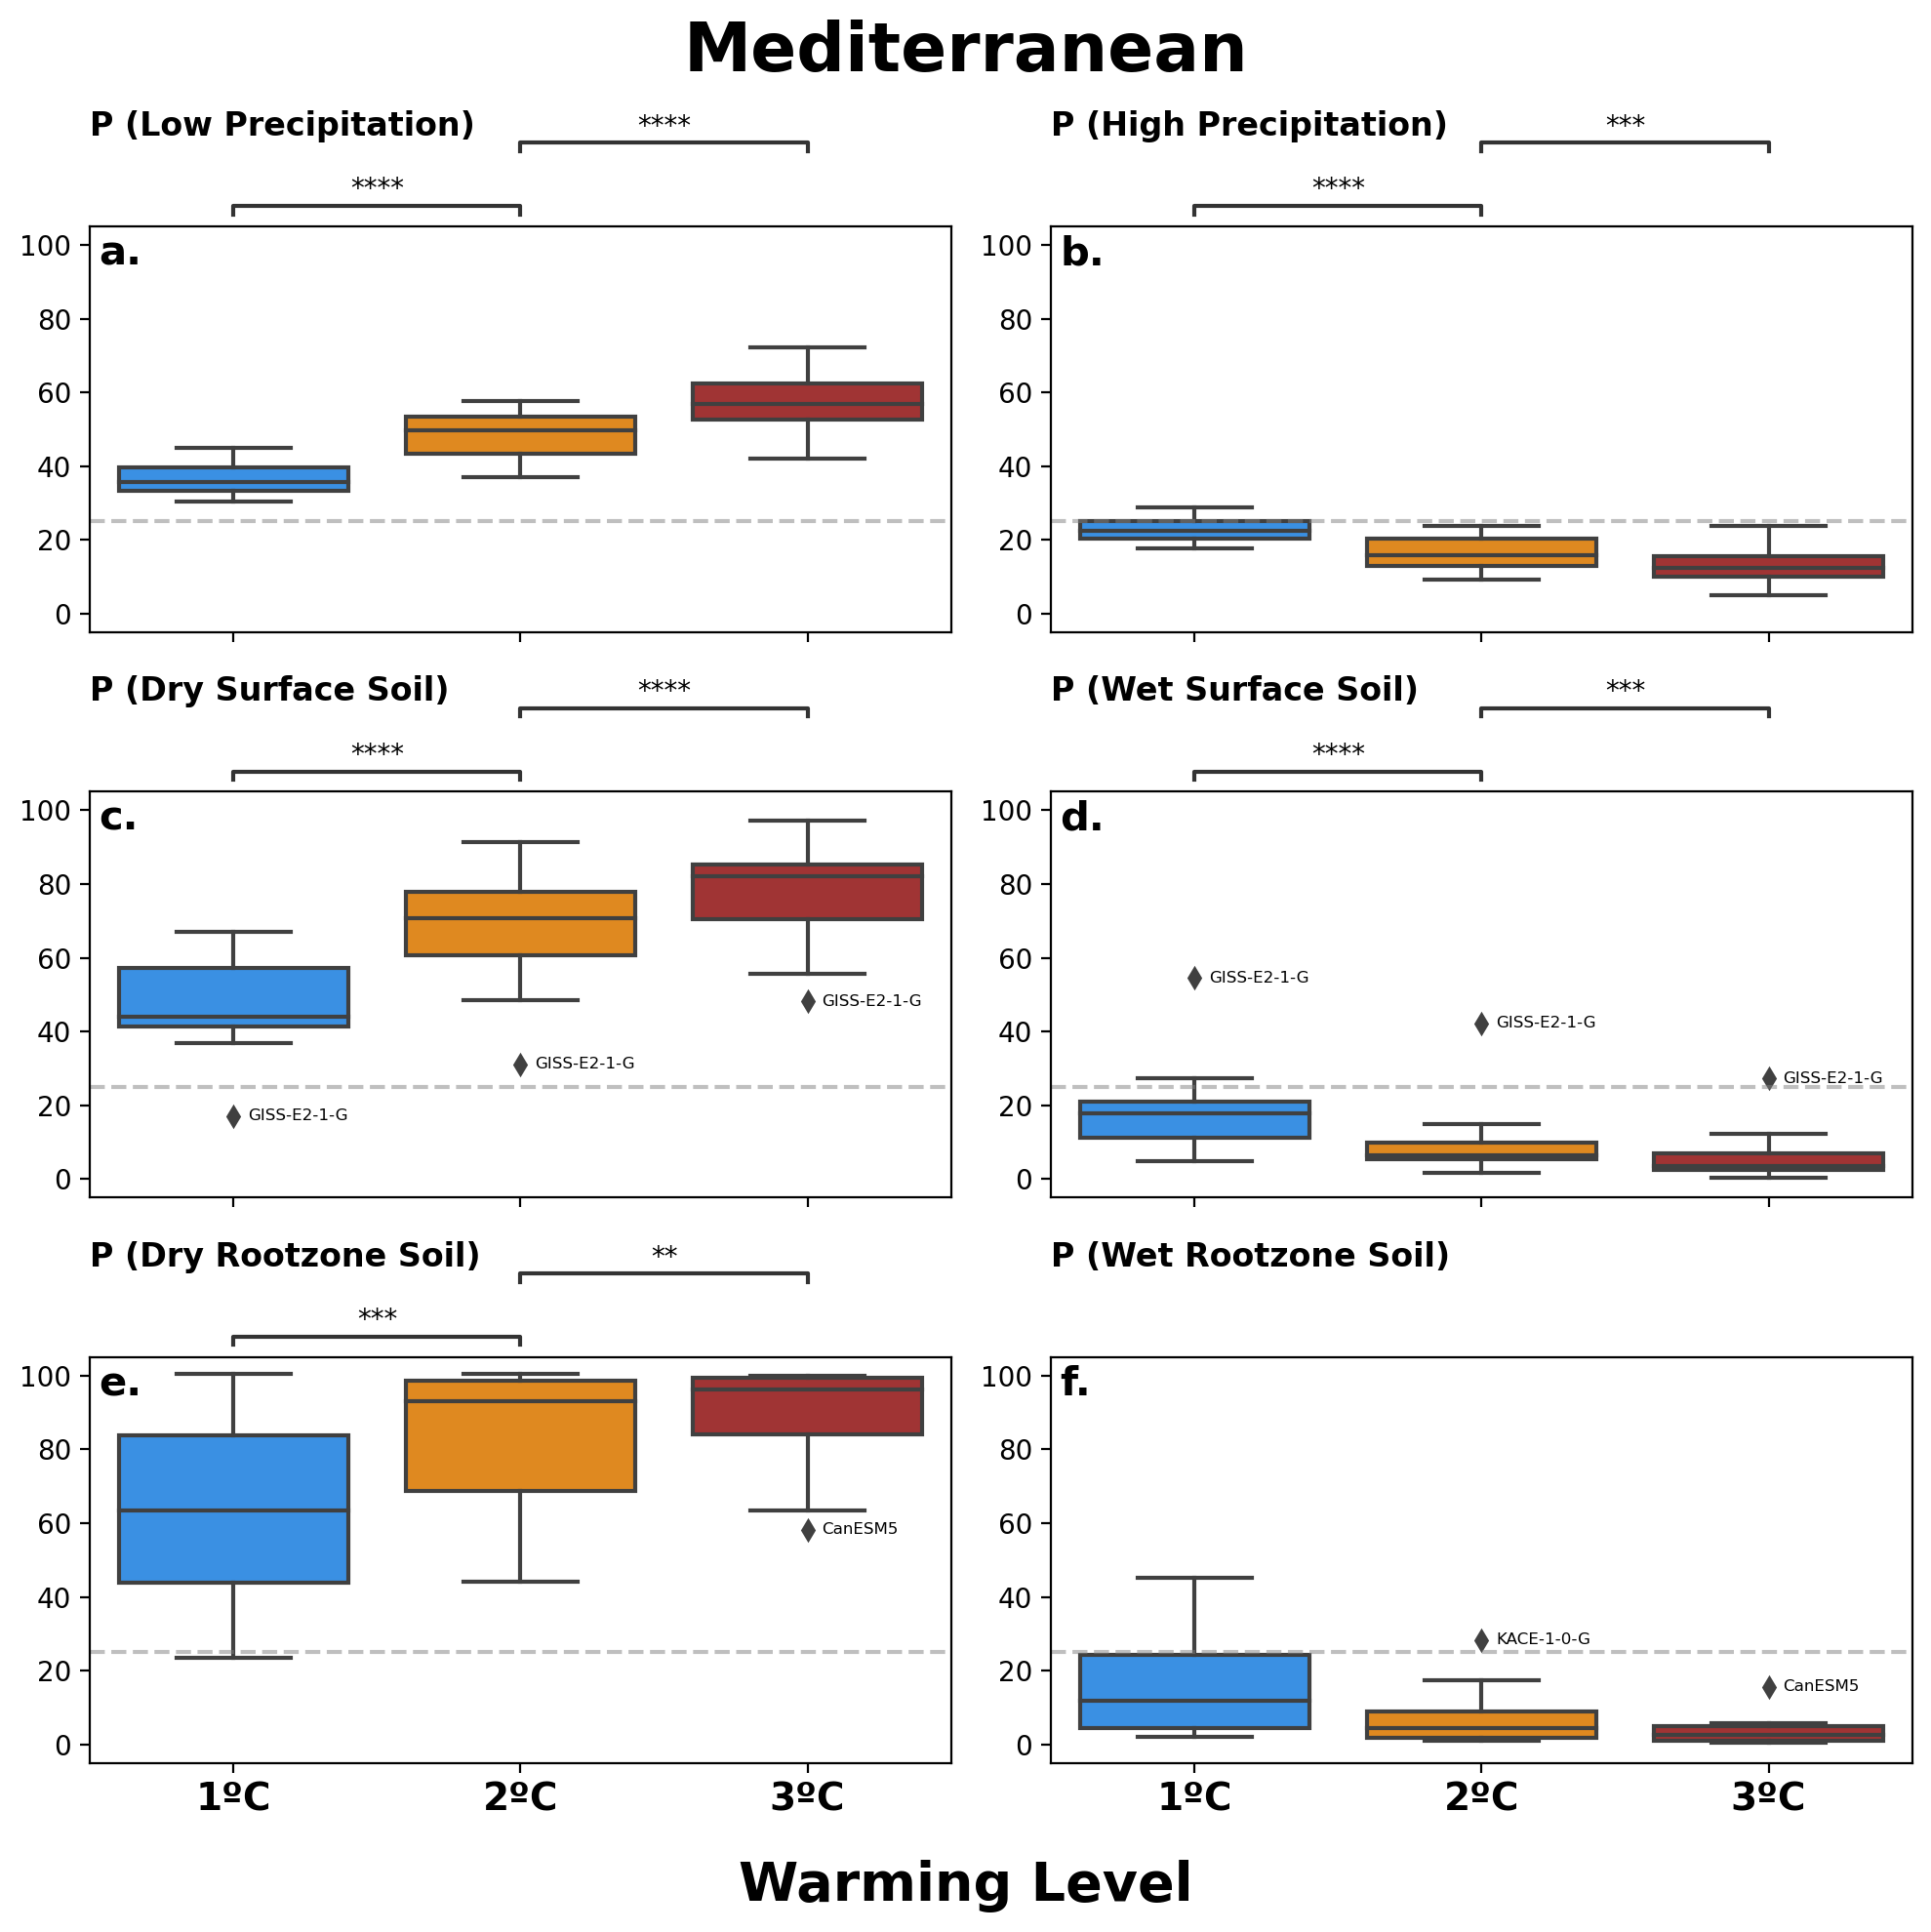

In [249]:
box_plot_likelihoods('MED', event_likelihoods, outliers = True)


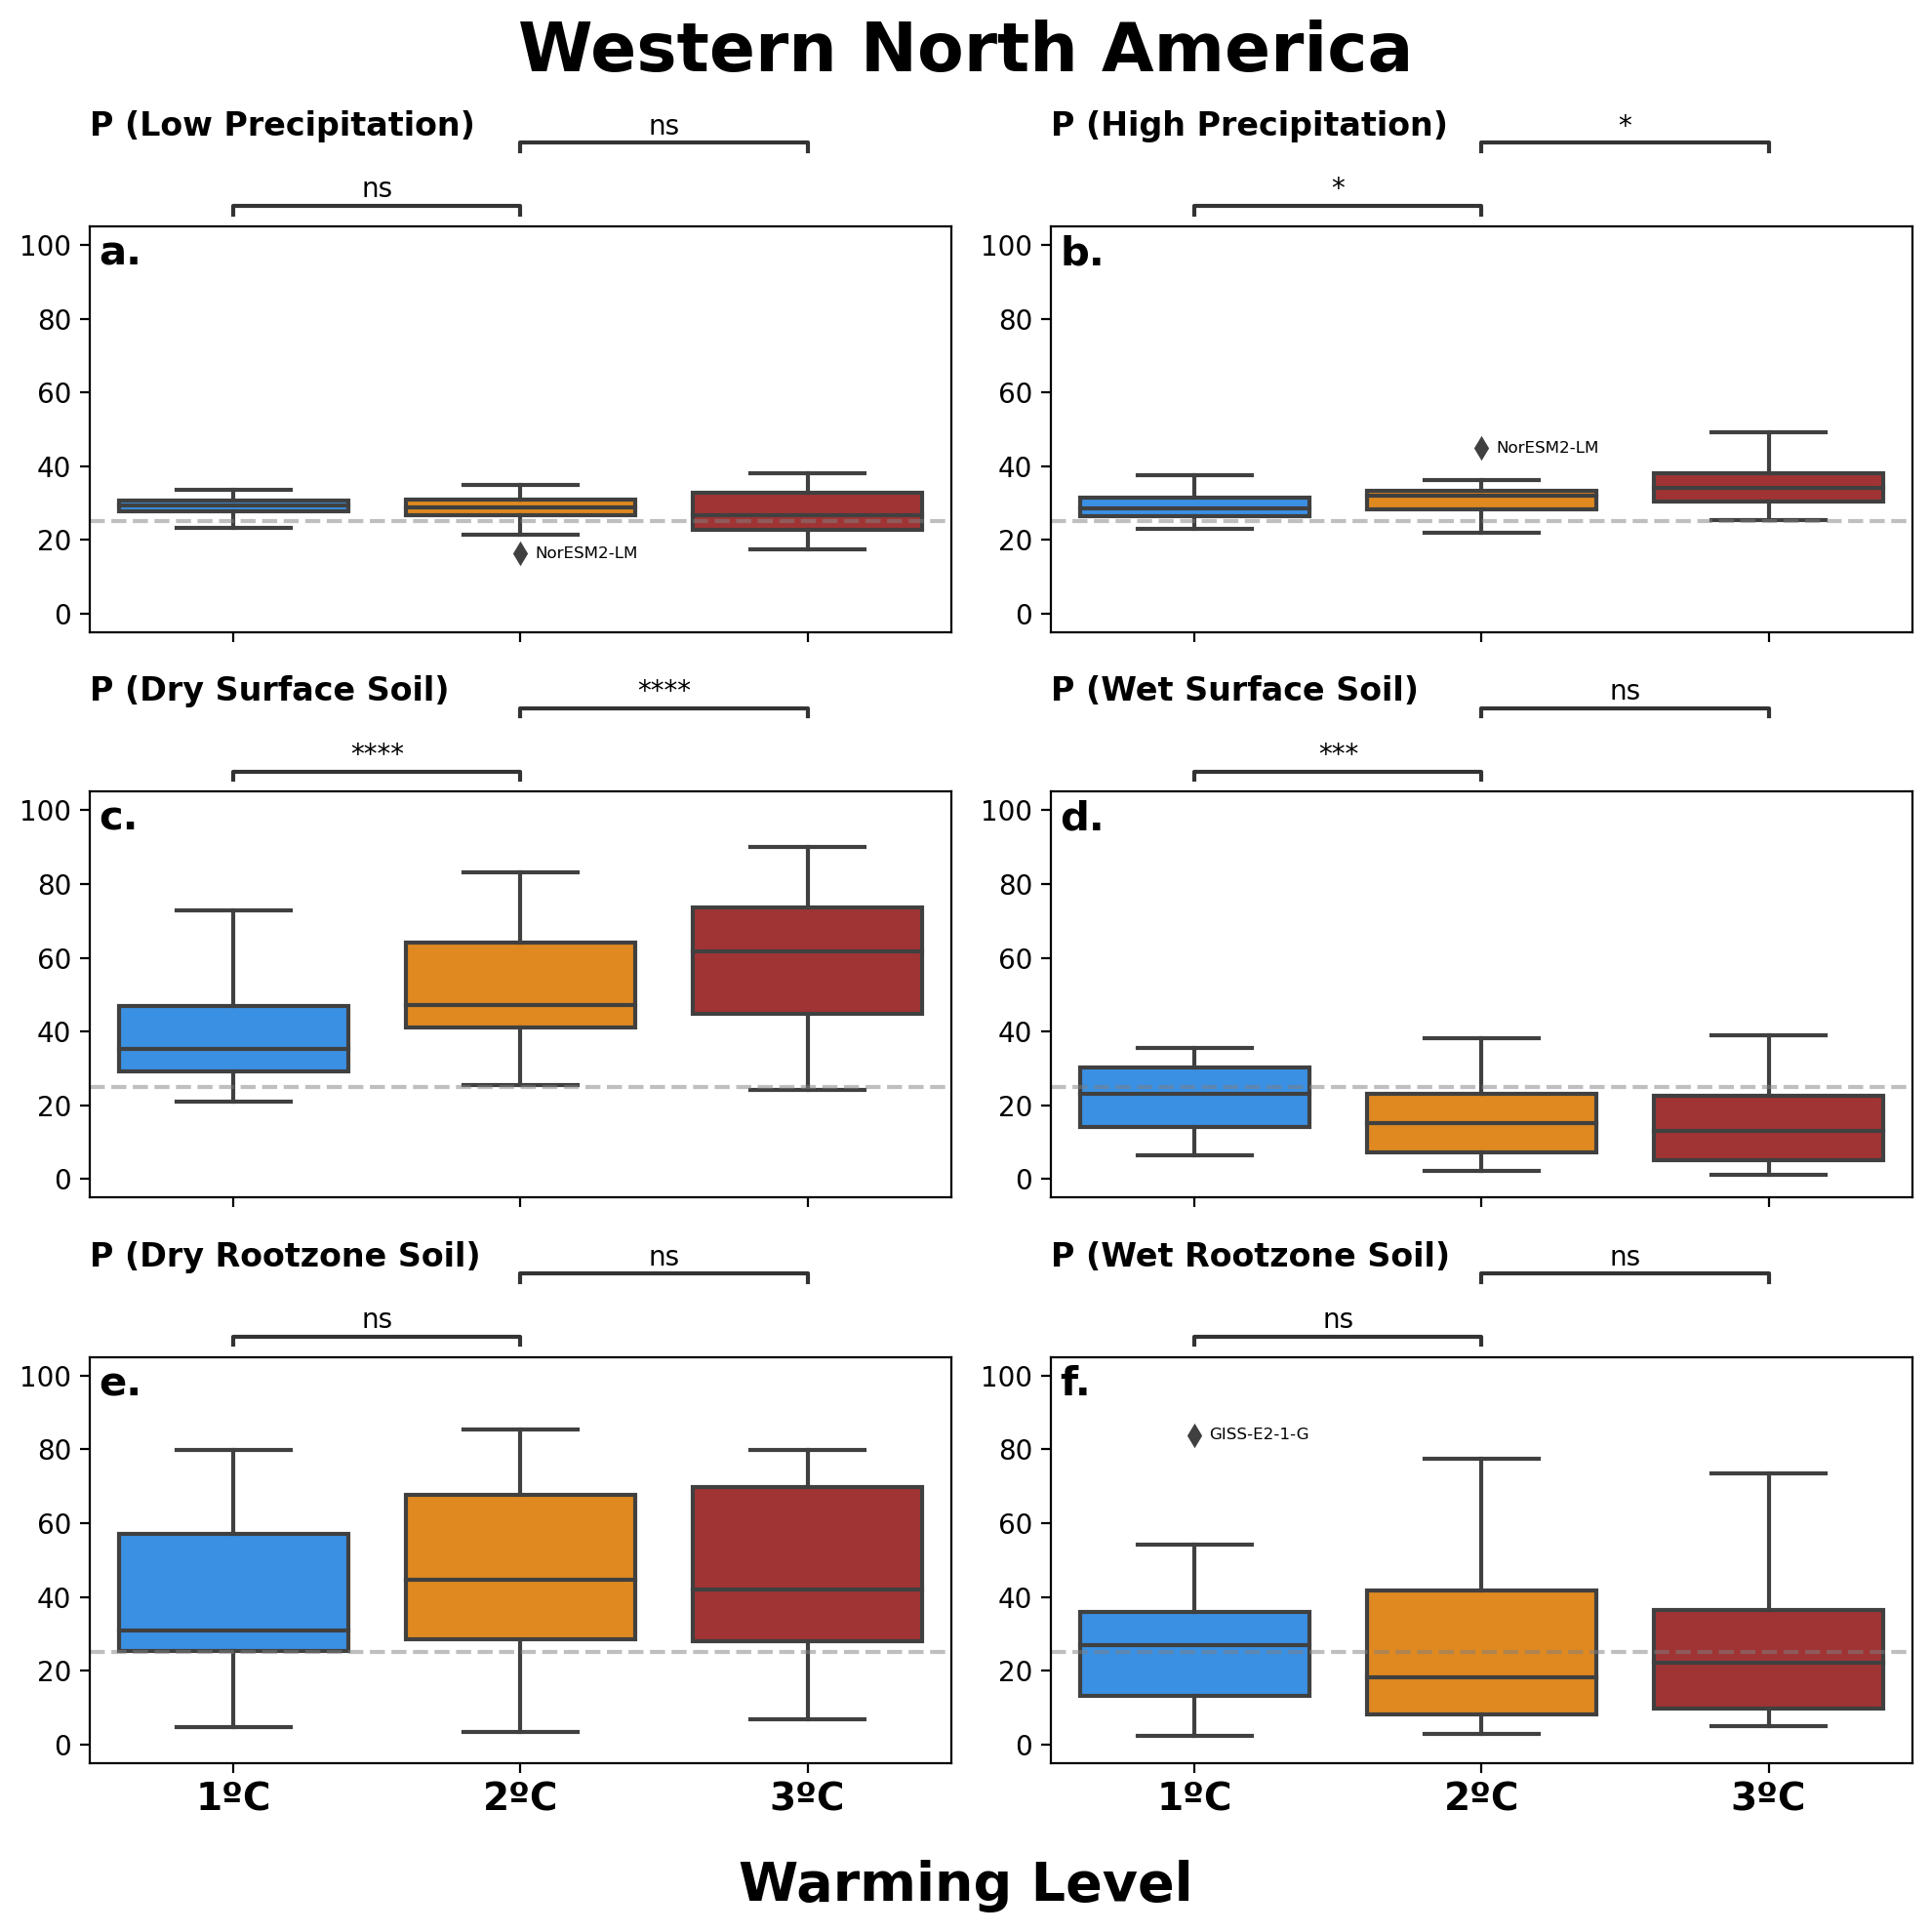

In [250]:
box_plot_likelihoods('WNA', event_likelihoods, outliers = True)

#### Single box plots

In [251]:
#single_box_plot_likelihoods('MED', event_likelihoods, ('mrsos_anom', 25))

In [252]:
#single_box_plot_likelihoods('MED', event_likelihoods, ('spi_1', 75))

In [253]:
#single_box_plot_likelihoods('WNA', event_likelihoods, ('spi_1', 75))

In [254]:
#single_box_plot_likelihoods('WNA', event_likelihoods, ('mrsos_anom', 25))

### Numbers for Paper

In [255]:
def percent_change(start_value, final_value):
    
    percent_increase = (final_value - start_value)/start_value * 100
    
    return percent_increase

def multiple_more_likely(start_value, final_value):
    
    if start_value > final_value:
        multiple_more_likely = (start_value / final_value)

    if start_value < final_value:
        multiple_more_likely = (final_value / start_value)

    return multiple_more_likely


In [256]:
def reg_longname(region):
    if region == 'MED':
        region_longname = 'Mediterranean'
    if region == 'WNA':
        region_longname = 'Western North America'
    
    return(region_longname)

def var_longname(variable):
    if variable == 'mrsos_anom':
        variable_longname = 'Surface Soil Moisture Anomaly'
    if variable == 'mrsol_anom':
        variable_longname = 'Rootzone Soil Moisture Anomaly'
    return(variable_longname)


In [257]:
def changes_calculation_and_print(region, percentile, variable, mean_or_median = 'MEAN', full = True):
    
    variable_longname = var_longname(variable)
    region_longname = reg_longname(region)

    df = event_likelihoods.groupby(['region', 'model', 'warming_level', 'variable', 'percentile']).mean()[['event_likelihood']].reset_index()
    df_select = df[(df.region == region) & (df.variable == variable) & (df.percentile == percentile)]

    if mean_or_median == 'MEAN':
        print('MEAN CHANGES')
        two_degree_likelihood = np.round(df_select.groupby('warming_level').mean()['event_likelihood'][1],2)
        three_degree_likelihood = df_select.groupby('warming_level').mean()['event_likelihood'][2]
        df_select.groupby('warming_level').mean()

    if mean_or_median == 'MEDIAN':
        print('MEDIAN CHANGES')
        two_degree_likelihood = np.round(df_select.groupby('warming_level').median()['event_likelihood'][1],2)
        three_degree_likelihood = df_select.groupby('warming_level').median()['event_likelihood'][2]

    
    print(region_longname + ' changes in a ' + str(percentile) + 'th percentile ' + variable_longname + ' relative to baseline: ')

    print(str(np.round(multiple_more_likely(percentile, two_degree_likelihood), 2)) + ' times more likely at 2ºC')
    print(str(np.round(percent_change(percentile, two_degree_likelihood), 2)) + ' percent increase at 2ºC')
    ## add percent increase

    print(str(np.round(multiple_more_likely(percentile, three_degree_likelihood), 2)) + ' times more likely at 3ºC')
    print(str(np.round(percent_change(percentile, three_degree_likelihood), 2)) + ' percent increase at 3ºC')
    ## add percent increase
    
    if full == True:
        if mean_or_median == 'MEAN':
            print(df_select.groupby('warming_level').mean())

        if mean_or_median == 'MEDIAN':
            print(df_select.groupby('warming_level').median())

Dry surface soil moisture and rootzone soil moisture months are **2.8 and 3.8** times more likely to occur under 2ºC of warming than during the preindustrial baseline period.

By 3ºC of warming, dry rootzone soil moisture events (Figure 3e.) become even more likely, occurring on average more than **96\%** of the time.

In [258]:
changes_calculation_and_print('MED', 25, 'mrsos_anom', 'MEDIAN', full = False)
changes_calculation_and_print('MED', 25, 'mrsol_anom', 'MEDIAN', full = False)
changes_calculation_and_print('MED', 25, 'mrsol_anom', 'MEDIAN', full = True)

MEDIAN CHANGES
Mediterranean changes in a 25th percentile Surface Soil Moisture Anomaly relative to baseline: 
2.83 times more likely at 2ºC
182.52 percent increase at 2ºC
3.29 times more likely at 3ºC
228.65 percent increase at 3ºC
MEDIAN CHANGES
Mediterranean changes in a 25th percentile Rootzone Soil Moisture Anomaly relative to baseline: 
3.72 times more likely at 2ºC
271.8 percent increase at 2ºC
3.85 times more likely at 3ºC
285.09 percent increase at 3ºC
MEDIAN CHANGES
Mediterranean changes in a 25th percentile Rootzone Soil Moisture Anomaly relative to baseline: 
3.72 times more likely at 2ºC
271.8 percent increase at 2ºC
3.85 times more likely at 3ºC
285.09 percent increase at 3ºC
               percentile  event_likelihood
warming_level                              
1                    25.0         63.436123
2                    25.0         92.951542
3                    25.0         96.271930
baseline             25.0         25.000000


Though the probability of high-precipitation monthly anomalies increases in Western North America, drought risk also increases due to increases in evaporative demand: the median probability of a dry surface soil moisture month increases significantly by **88\% and 147\%** at 2 and 3ºC of warming relative to the preindustrial baseline, a massive increase in risk of these events. 

In [260]:
changes_calculation_and_print('WNA', 25, 'mrsos_anom', 'MEDIAN', full = False)


MEDIAN CHANGES
Western North America changes in a 25th percentile Surface Soil Moisture Anomaly relative to baseline: 
1.88 times more likely at 2ºC
88.16 percent increase at 2ºC
2.47 times more likely at 3ºC
147.37 percent increase at 3ºC


At all degrees of warming, the mulitmodel mean and median probability of a dry surface soil moisture anomaly increases in both the Mediterranean and Western North America, with the median probability increasing from the baseline to 2ºC of warming by **182\% (Mediterranean) and 88\% (Western North America)**.

In [261]:
changes_calculation_and_print('MED', 25, 'mrsos_anom', 'MEDIAN', full = False)
changes_calculation_and_print('WNA', 25, 'mrsos_anom', 'MEDIAN', full = False)


MEDIAN CHANGES
Mediterranean changes in a 25th percentile Surface Soil Moisture Anomaly relative to baseline: 
2.83 times more likely at 2ºC
182.52 percent increase at 2ºC
3.29 times more likely at 3ºC
228.65 percent increase at 3ºC
MEDIAN CHANGES
Western North America changes in a 25th percentile Surface Soil Moisture Anomaly relative to baseline: 
1.88 times more likely at 2ºC
88.16 percent increase at 2ºC
2.47 times more likely at 3ºC
147.37 percent increase at 3ºC


#### Event likelihood counts 

Across the multi-model ensemble, there was an average of 13 moderately wet months of surface soil moisture at 3ºC of warming per model member, compared to 60 months during the baseline period.

In [262]:
region = 'MED'
variable = 'mrsos_anom'
percentile = 75

subset_df = events_df[(events_df.region == region) & (events_df.variable == variable) & (events_df.percentile == percentile)]


print('Average number 75th percentile surface soil moisture events in the Mediterranean per warming level')

(subset_df[['model', 'member_id', 'warming_level', 'value']].groupby(['model','warming_level', 'member_id'])
 .count().reset_index().groupby(['model', 'warming_level']).mean().reset_index()
 .rename(columns={"value": "Event count"}).groupby('warming_level').mean())




Average number 75th percentile surface soil moisture events in the Mediterranean per warming level


,Event count
warming_level,
1,41.236550
2,19.957120
3,13.027193
baseline,60.000000


In [263]:
region = 'MED'
variable = 'mrsol_anom'
percentile = 75

subset_df = events_df[(events_df.region == region) & (events_df.variable == variable) & (events_df.percentile == percentile)]

print('Average number 75th percentile rootzone soil moisture events in the Mediterranean per warming level')

(subset_df[['model', 'member_id', 'warming_level', 'value']].groupby(['model','warming_level', 'member_id'])
 .count().reset_index().groupby(['model', 'warming_level']).mean().reset_index()
 .rename(columns={"value": "avg event count"}).groupby('warming_level').mean())




Average number 75th percentile rootzone soil moisture events in the Mediterranean per warming level


,avg event count
warming_level,
1,34.360803
2,18.089316
3,8.523115
baseline,60.000000


### Conditional Likelihoods

Given a precipitation event, what is the likelihood of a soil moisture drought? 

In [264]:
def get_crossing_times(model, level, exp = 'ssp585', GWL = GWL):
    
    if level == 'baseline':
        start_date = pd.Timestamp('1861-01-01')
        end_date = pd.Timestamp('1881-01-01')
    
    else:
        start_date = GWL[(GWL.model == model) & 
                         (GWL.exp == exp) & (GWL.warming_level == level)].start_year.iloc[0]

        end_date = GWL[(GWL.model == model) & 
                       (GWL.exp == exp) & (GWL.warming_level == level)].end_year.iloc[0]
        
    return (start_date, end_date)

def get_events_multivariable(models, model_anoms, region, high_low_or_normal, event_variable = 'spi_1', percentile = 25):

    tidy_tmp = []
    
    for model in tqdm(models):
        print(model)
        ds = model_anoms[region][model].sel(depth = '200cm')
        p = model_anoms[region][model][event_variable]

        baseline = ds.sel(time = slice('1860', '1880'))

        events_array = []
        ### not the best code, but warming_levels was defined globally above....
        #for level in warming_levels:
        for level in ['baseline' , 1, 2, 3]:
            start_date, end_date = get_crossing_times(model, level)

            tmp = []
            for month in np.arange(1,13):

                for member in ds.member_id.data:                    
                    var_month_baseline = baseline.sel(time = baseline.time.dt.month.isin([month]), member_id = member)
                    month_percentile = np.nanpercentile(var_month_baseline[variable], percentile)

                    ds_level = ds.sel(time = slice(str(start_date), str(end_date)))
                    var_month = ds_level.sel(time = ds_level.time.dt.month.isin([month]), member_id = member)

                    if high_low_or_normal == 'low':
                        tmp.append(var_month.where(var_month[event_variable] < month_percentile, drop = True))

                    if high_low_or_normal == 'high':
                        tmp.append(var_month.where(var_month[event_variable] > month_percentile, drop = True))
                        
                    if high_low_or_normal == 'normal':
                        ## define the upper and lower limits of the normal percentile 
                        month_percentile_lower = np.nanpercentile(var_month_baseline[variable], 33)
                        month_percentile_upper = np.nanpercentile(var_month_baseline[variable], 66)
                        tmp.append(var_month.where(var_month[event_variable] < month_percentile_upper, 
                                                   drop = True).where(var_month[event_variable] > month_percentile_lower, 
                                                                      drop = True)) 

            index = xr.concat(tmp, dim = 'time')
            
            index_pd = index.to_pandas()
            
            index_pd['warming_level'] = level

            events_array.append(index_pd)

        events_array = pd.concat(events_array).reset_index()
        #tidy_events_array = events_array[['mrsos','mrsol', 'pr', 'warming_level']]
        tidy_events_array = events_array[[ event_variable, 'warming_level', 'time', 'member_id','mrsos_anom', 'mrsol_anom']]
        
        tidy_events_array['model'] = model
        tidy_events_array['percentile'] = percentile
        tidy_events_array['high_low_or_normal'] = high_low_or_normal
        tidy_events_array['region'] = region
        
        tidy_tmp.append(tidy_events_array)

        #full_events[model] = events_array
        #events[model] = tidy_events_array
    
    events = pd.concat(tidy_tmp).reset_index()
        
    return events

In [265]:
precip_event_types = ['spi_1_low',
                      'spi_1_high', 
                      'spi_1_normal',
                      'spi_3_low',
                      'spi_3_high',
                      'spi_3_normal',
                      'spi_6_low', 
                      'spi_6_high', 
                      'spi_6_normal'
                     ]

In [266]:
def find_precip_events():
    precip_event_types = ['spi_1_low',
                          'spi_1_high', 
                          'spi_1_normal',
                          'spi_3_low',
                          'spi_3_high',
                          'spi_3_normal',
                          'spi_6_low', 
                          'spi_6_high', 
                          'spi_6_normal'
                         ]
    precip_events = dict()

    for precip_event in tqdm(precip_event_types):
        print('... starting ' + precip_event + ' ...')
        tmp = []
        for region in tqdm(regions):
            print('*** starting ' + region + ' ***')


            split = precip_event.split('_')

            precip_type = split[0] + '_' + split[1]
            high_low_or_normal = split[-1]

            if high_low_or_normal == 'low':
                percentile = 25
                print(percentile)

            if high_low_or_normal == 'high':
                percentile = 75
                print(percentile)
                
            if high_low_or_normal == 'normal':
                percentile = 50

            event_pd_tmp = get_events_multivariable(models, model_anoms, region, 
                                                                   high_low_or_normal = high_low_or_normal, 
                                                                   event_variable = precip_type, 
                                                                   percentile = percentile)

            event_pd_tmp['high_or_low'] = high_low_or_normal

            event_pd_tmp['precip_event'] = precip_event
            tmp.append(event_pd_tmp)

        precip_events[precip_event] = pd.concat(tmp)
        
    return precip_events

In [267]:
# # # this takes about 25 minutes (most recent run - 25min 19s)
# %time precip_events = find_precip_events()

# precip_spi_1 = pd.concat([precip_events[precip_event_types[0]], 
#                           precip_events[precip_event_types[1]],
#                           precip_events[precip_event_types[2]]
#                          ])
# precip_spi_3 = pd.concat([precip_events[precip_event_types[3]], 
#                           precip_events[precip_event_types[4]], 
#                           precip_events[precip_event_types[5]]
#                          ])
# precip_spi_6 = pd.concat([precip_events[precip_event_types[6]], 
#                           precip_events[precip_event_types[7]], 
#                           precip_events[precip_event_types[8]]
#                          ])

### PRECIP_SPI Saves

- v1: first version (in v1 of manuscrip submission)
- v2: includes 'normal' defined as 25 <= x <= 75
- v3: includes 'normal' defined as 33 < x < 66

In [268]:
# precip_spi_1 = pd.concat([precip_events[precip_event_types[0]], precip_events[precip_event_types[1]]])
# precip_spi_3 = pd.concat([precip_events[precip_event_types[2]], precip_events[precip_event_types[3]]])
# precip_spi_6 = pd.concat([precip_events[precip_event_types[4]], precip_events[precip_event_types[5]]])

In [269]:
# precip_spi_1.to_csv('~/precip-events/exported_data/events/precip_spi_1.csv', index = False)
# precip_spi_3.to_csv('~/precip-events/exported_data/events/precip_spi_3.csv', index = False)
# precip_spi_6.to_csv('~/precip-events/exported_data/events/precip_spi_6.csv', index = False)

In [270]:
# precip_spi_1 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_1.csv')
# precip_spi_3 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_3.csv')
# precip_spi_6 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_6.csv')

In [271]:
# old version (from submitted) 
## these plots are different (figure out why) 

precip_spi_1 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v1/precip_spi_1.csv')
precip_spi_3 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v1/precip_spi_3.csv')
precip_spi_6 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v1/precip_spi_6.csv')

In [272]:
def get_event_likelihood(models, response_variable, precip_events_pd, dictionary_of_models_xr):
    
    clean_dict = precip_events_pd
    model_anoms = dictionary_of_models_xr
    
    low_percentile = 25
    high_percentile = 75
    warming_levels = ['baseline', '1', '2', '3']
    
    variable = response_variable
    
    percentile_df = pd.DataFrame()

    for model in models:
        #df = clean_dict[model][[variable, 'warming_level']]
        df = clean_dict[clean_dict.model == model][[variable, 'warming_level']]

        percentile_low = []
        percentile_high = []

        ds = model_anoms[model].mean(dim = 'member_id').sel(time = slice('1861', '1880'))[variable]

        # get score for low percentile event (25th percentile soil moisture level per model (mean of member_ids))
        low_response_score = np.nanpercentile(ds, low_percentile)
        # get score for high percentile event (75 percentile soil moisture level per model (mean of member_ids))
        high_response_score = np.nanpercentile(ds, high_percentile)
        for level in warming_levels:   
        #for level in ['baseline', 1,1,3]:
            df_warming_level = df[df.warming_level == level]
            
            ### A percentileofscore of, for example, 80% means that 80% of the scores in a are below the given score.             
            percentile_low.append(stats.percentileofscore(df_warming_level[variable], low_response_score))
            percentile_high.append(100 - stats.percentileofscore(df_warming_level[variable], high_response_score))

        model_percentile_df = pd.DataFrame({
            ('model'): model,
            ('warming_level'): warming_levels,
            ('variable'): variable,
            ('low_percentile'): percentile_low,
            ('high_percentile'): percentile_high
            })

        percentile_df = percentile_df.append(model_percentile_df)
    
    return percentile_df   

In [273]:
from collections import OrderedDict

In [274]:
# for old version without 'normal' events:

relative_events_likelihood = dict()

for region in regions: 
    relative_events_likelihood[region] = ({
        'sm_surface_low_pr_events' : get_event_likelihood(models = models, response_variable = 'mrsos_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'low') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_surface_high_pr_events' : get_event_likelihood(models = models, response_variable = 'mrsos_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'high') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_1_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'low') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_1_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'high') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_3_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_3[(precip_spi_3.high_or_low == 'low') & (precip_spi_3.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_3_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_3[(precip_spi_3.high_or_low == 'high') & (precip_spi_3.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_6_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_6[(precip_spi_6.high_or_low == 'low') & (precip_spi_6.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_6_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_6[(precip_spi_6.high_or_low == 'high') & (precip_spi_6.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
    })


In [275]:
def boxplot_relative_event_likelihood(dictionary, region, order = None, normal = False, outliers = False):

    events_likelihood = dictionary
    event_percentile = ['low_percentile','high_percentile']
    
    palette = ['grey', 'dodgerblue', 'darkorange', 'firebrick']
    
    nrows = len(events_likelihood.keys())
    ncols = 2
    
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharey = False, figsize = [12,14], sharex = True)
    
    if order is None:
        event_keys = events_likelihood.keys()
        
    if order is not None:
        event_keys = order
    
    ax[0,0].set_title('P (Dry Surface Soil | Low Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[0,1].set_title('P (Wet Surface Soil | Low Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    
    ax[1,0].set_title('P (Dry Surface Soil | High Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[1,1].set_title('P (Wet Surface Soil | High Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    
    ax[2,0].set_title('P (Dry Rootzone Soil | Low Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[2,1].set_title('P (Wet Rootzone Soil | Low Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    
    ax[3,0].set_title('P (Dry Rootzone Soil | High Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[3,1].set_title('P (Wet Rootzone Soil | High Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    

    for axes, i in zip(ax.flat,np.arange(8)) :
        # Subplot lettering from kevin s
        axes.text(0.01,0.98,string.ascii_letters[i]+'.',
                transform=axes.transAxes,ha='left',va='top',
                fontsize=15,fontweight='bold',
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
        
        axes.set_ylim(-5, 105)

    if region is 'MED':
        fig.suptitle('Mediterranean', fontsize = 25, weight = 'bold')
    
    if region is 'WNA':
        fig.suptitle('Western North America', fontsize = 25, weight = 'bold')
    
    for event, row in zip(event_keys, np.arange(0, len(events_likelihood.keys()))):
        for severity, col in zip(event_percentile, [0,1]):
            
            data = events_likelihood[event]
            y = severity
            x = 'warming_level'
            
            sns.boxplot(data = data, y = y, x = x, ax = ax[row, col], 
                        palette = palette)
        
            pairs=[("baseline", "1"), ("1", "2"), ("2", "3")]

            ax[row,col].axhline(y = data[data.warming_level == 'baseline'][severity].median(), 
                                color = 'grey', alpha = 0.5, linestyle = '--') 

            ax[row,col].set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')

            ax[row,col].set_xlabel(None)
            ax[row,col].set_ylabel(None)
            
            annotator = Annotator(ax[row, col], pairs, data=data, x=x, y=y)
            annotator.configure(test='Wilcoxon', text_format='star', loc='outside', verbose = 0)
            annotator.apply_and_annotate()
        
                        ## FOR TESTING
            #ax[row, col].set_ylabel(severity + '|' + event)
            
            if outliers == True:
                severity_q1 = data.groupby(data.warming_level).quantile(0.25)[[y]].to_numpy()
                severity_q3 = data.groupby(data.warming_level).quantile(0.75)[[y]].to_numpy()
                outlier_bottom_lim = severity_q1 - 1.5 * (severity_q3 - severity_q1)
                outlier_top_lim = severity_q3 + 1.5 * (severity_q3 - severity_q1)

                warming_levels = ['baseline', '1', '2', '3']

                for r in data.itertuples():
                    
                    model = r[1]
                    gwlevel = r[2]
                    if y == 'low_percentile':
                        val = r[4]
                    if y == 'high_percentile':
                        val = r[5]

                    if val > outlier_top_lim[warming_levels.index(gwlevel)-1] or val < outlier_bottom_lim[warming_levels.index(gwlevel)-1]:
                        #print(model)
                        #print(gwlevel)
                        #print(val)
                        ax[row, col].text(s = model, x = warming_levels.index(gwlevel) + 0.09, y = val, ha = 'left', va = 'center', fontsize = 6)
        
    
        
    fig.supxlabel('Warming Level', fontsize = 20, weight = 'bold')
        
    plt.tight_layout()
    if normal == False:
        plt.savefig('figures/' + region + '_conditional_likelihood.png', dpi = 300, format = 'png')
    if normal == True:
        plt.savefig('figures/' + region + '_normal_conditional_likelihood.png', dpi = 300, format = 'png')


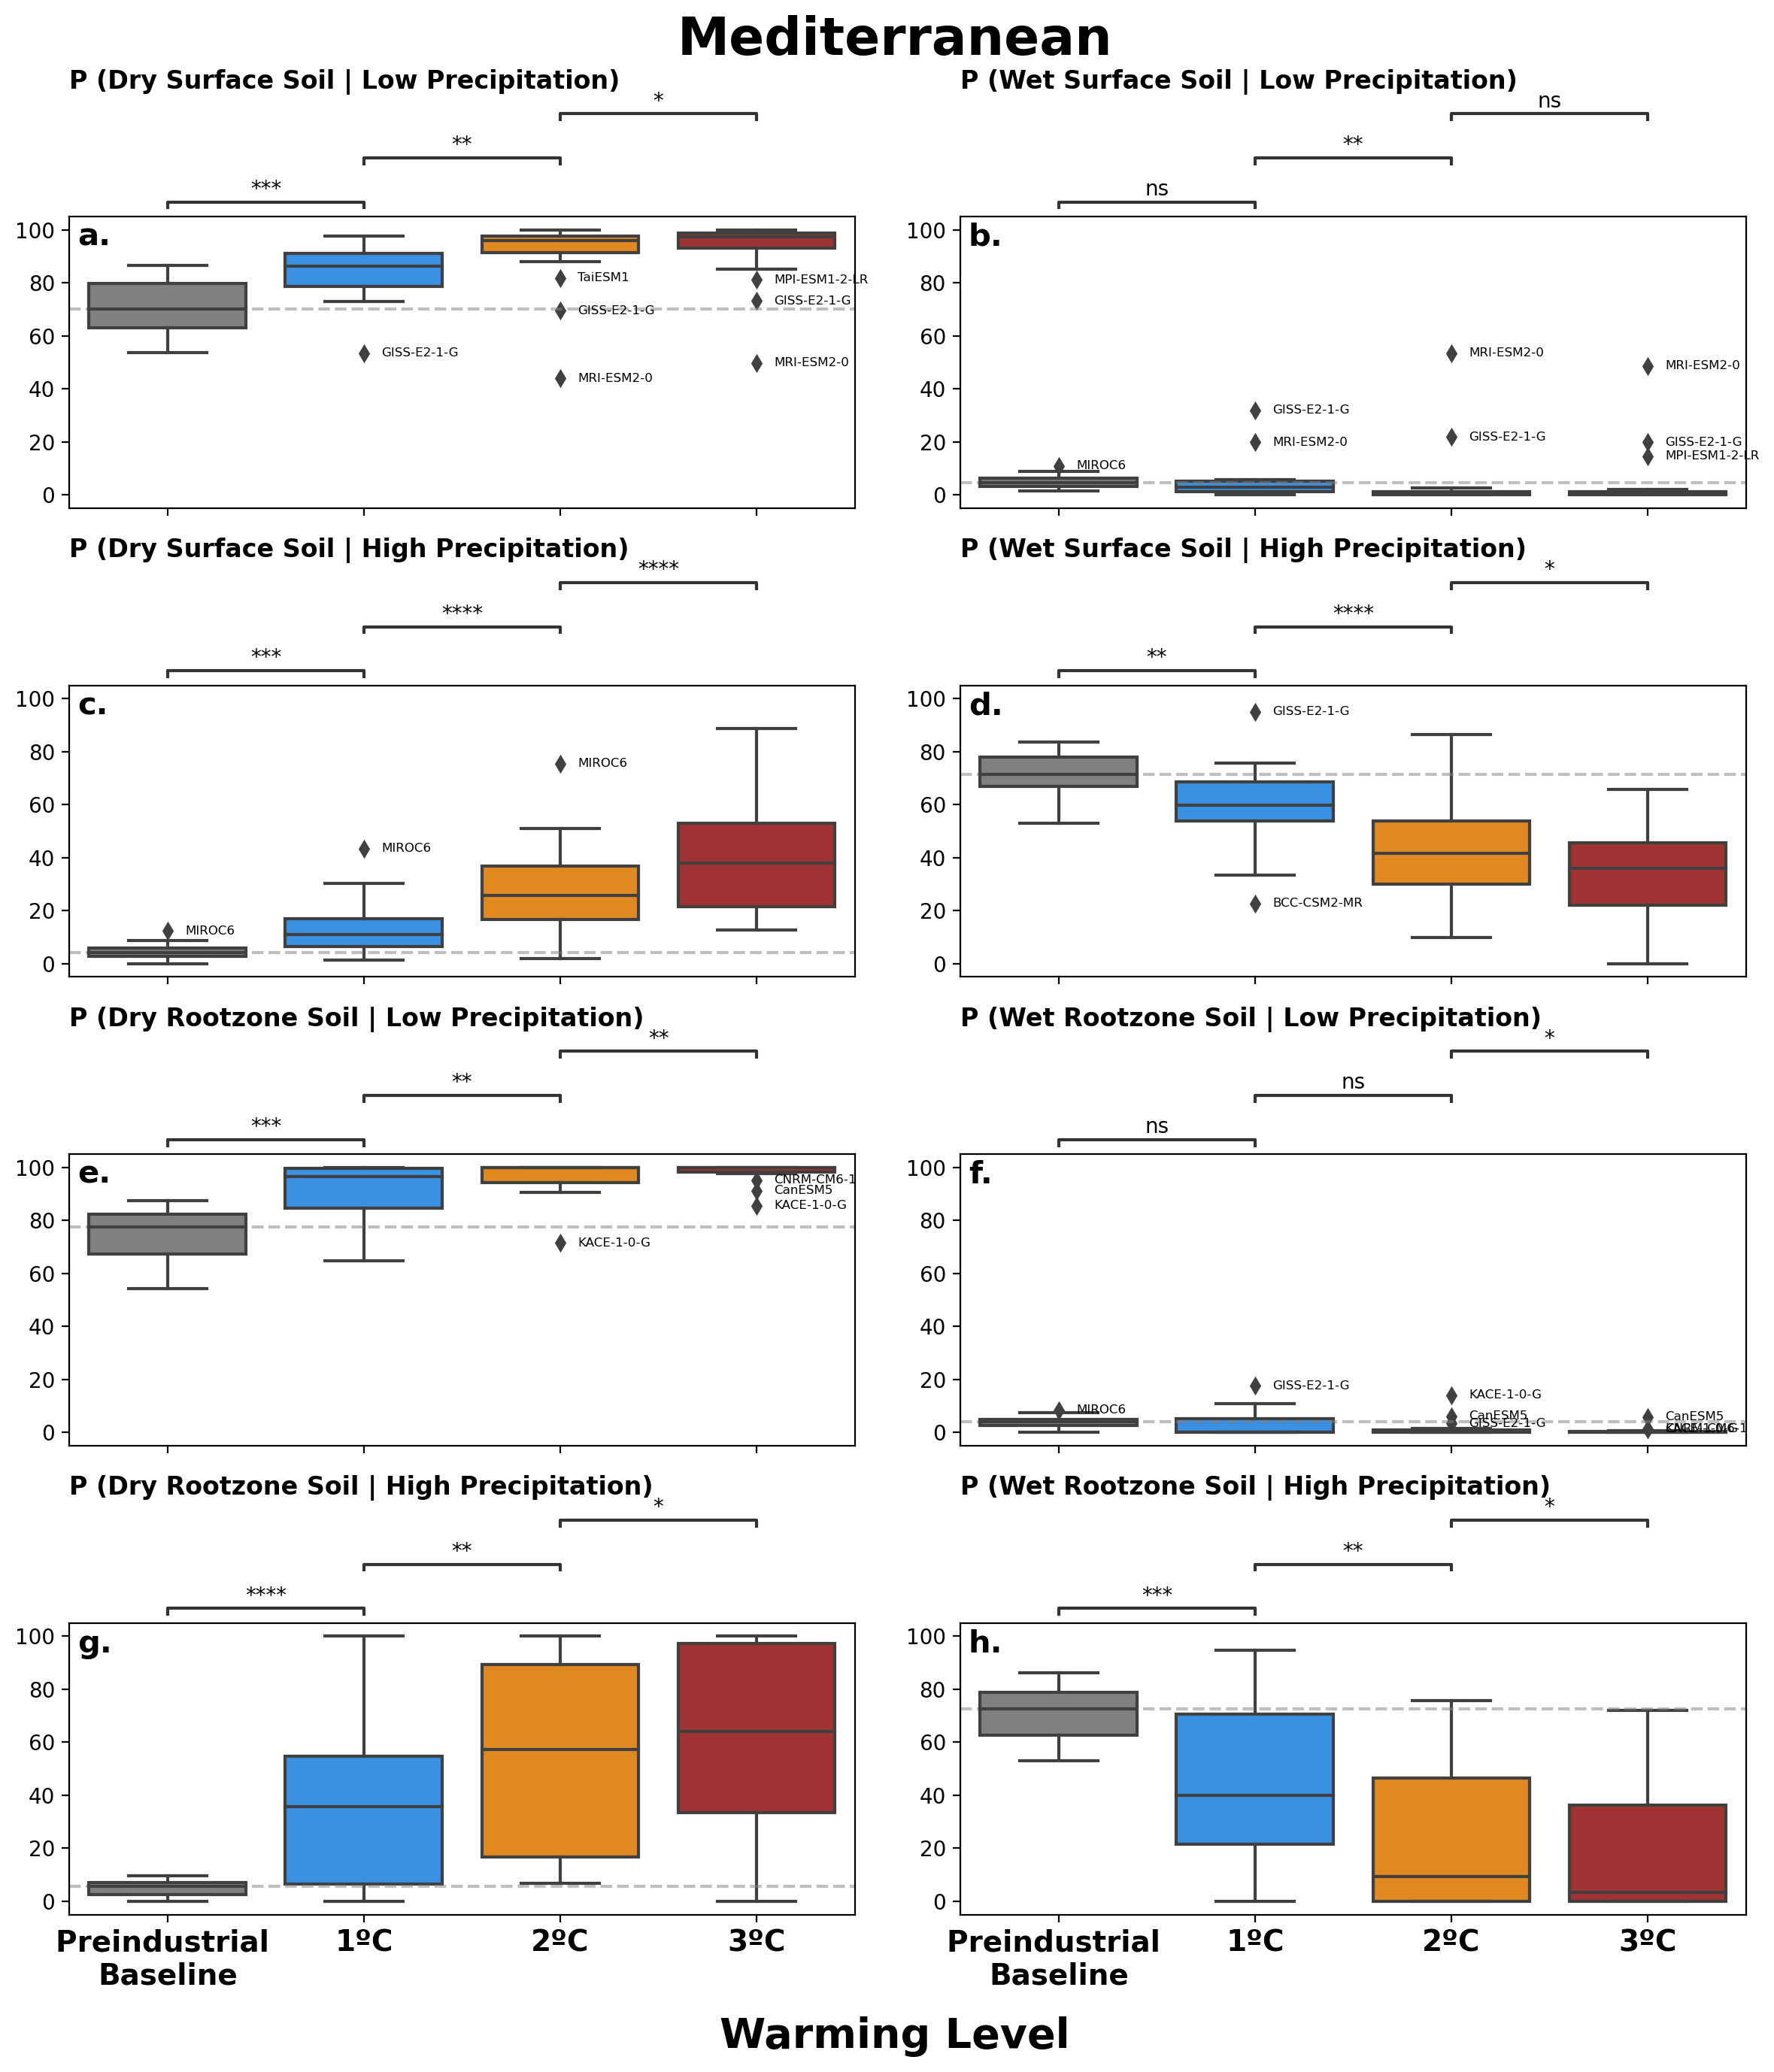

In [276]:
spi_1_6 = ['sm_surface_low_pr_events', 'sm_surface_high_pr_events', 'sm_200_low_spi_6_events', 'sm_200_high_spi_6_events']

spi_6_MED_events = {k: relative_events_likelihood['MED'][k] for k in relative_events_likelihood['MED'].keys() & spi_1_6}
boxplot_relative_event_likelihood(spi_6_MED_events, 'MED', order = spi_1_6, outliers = True)

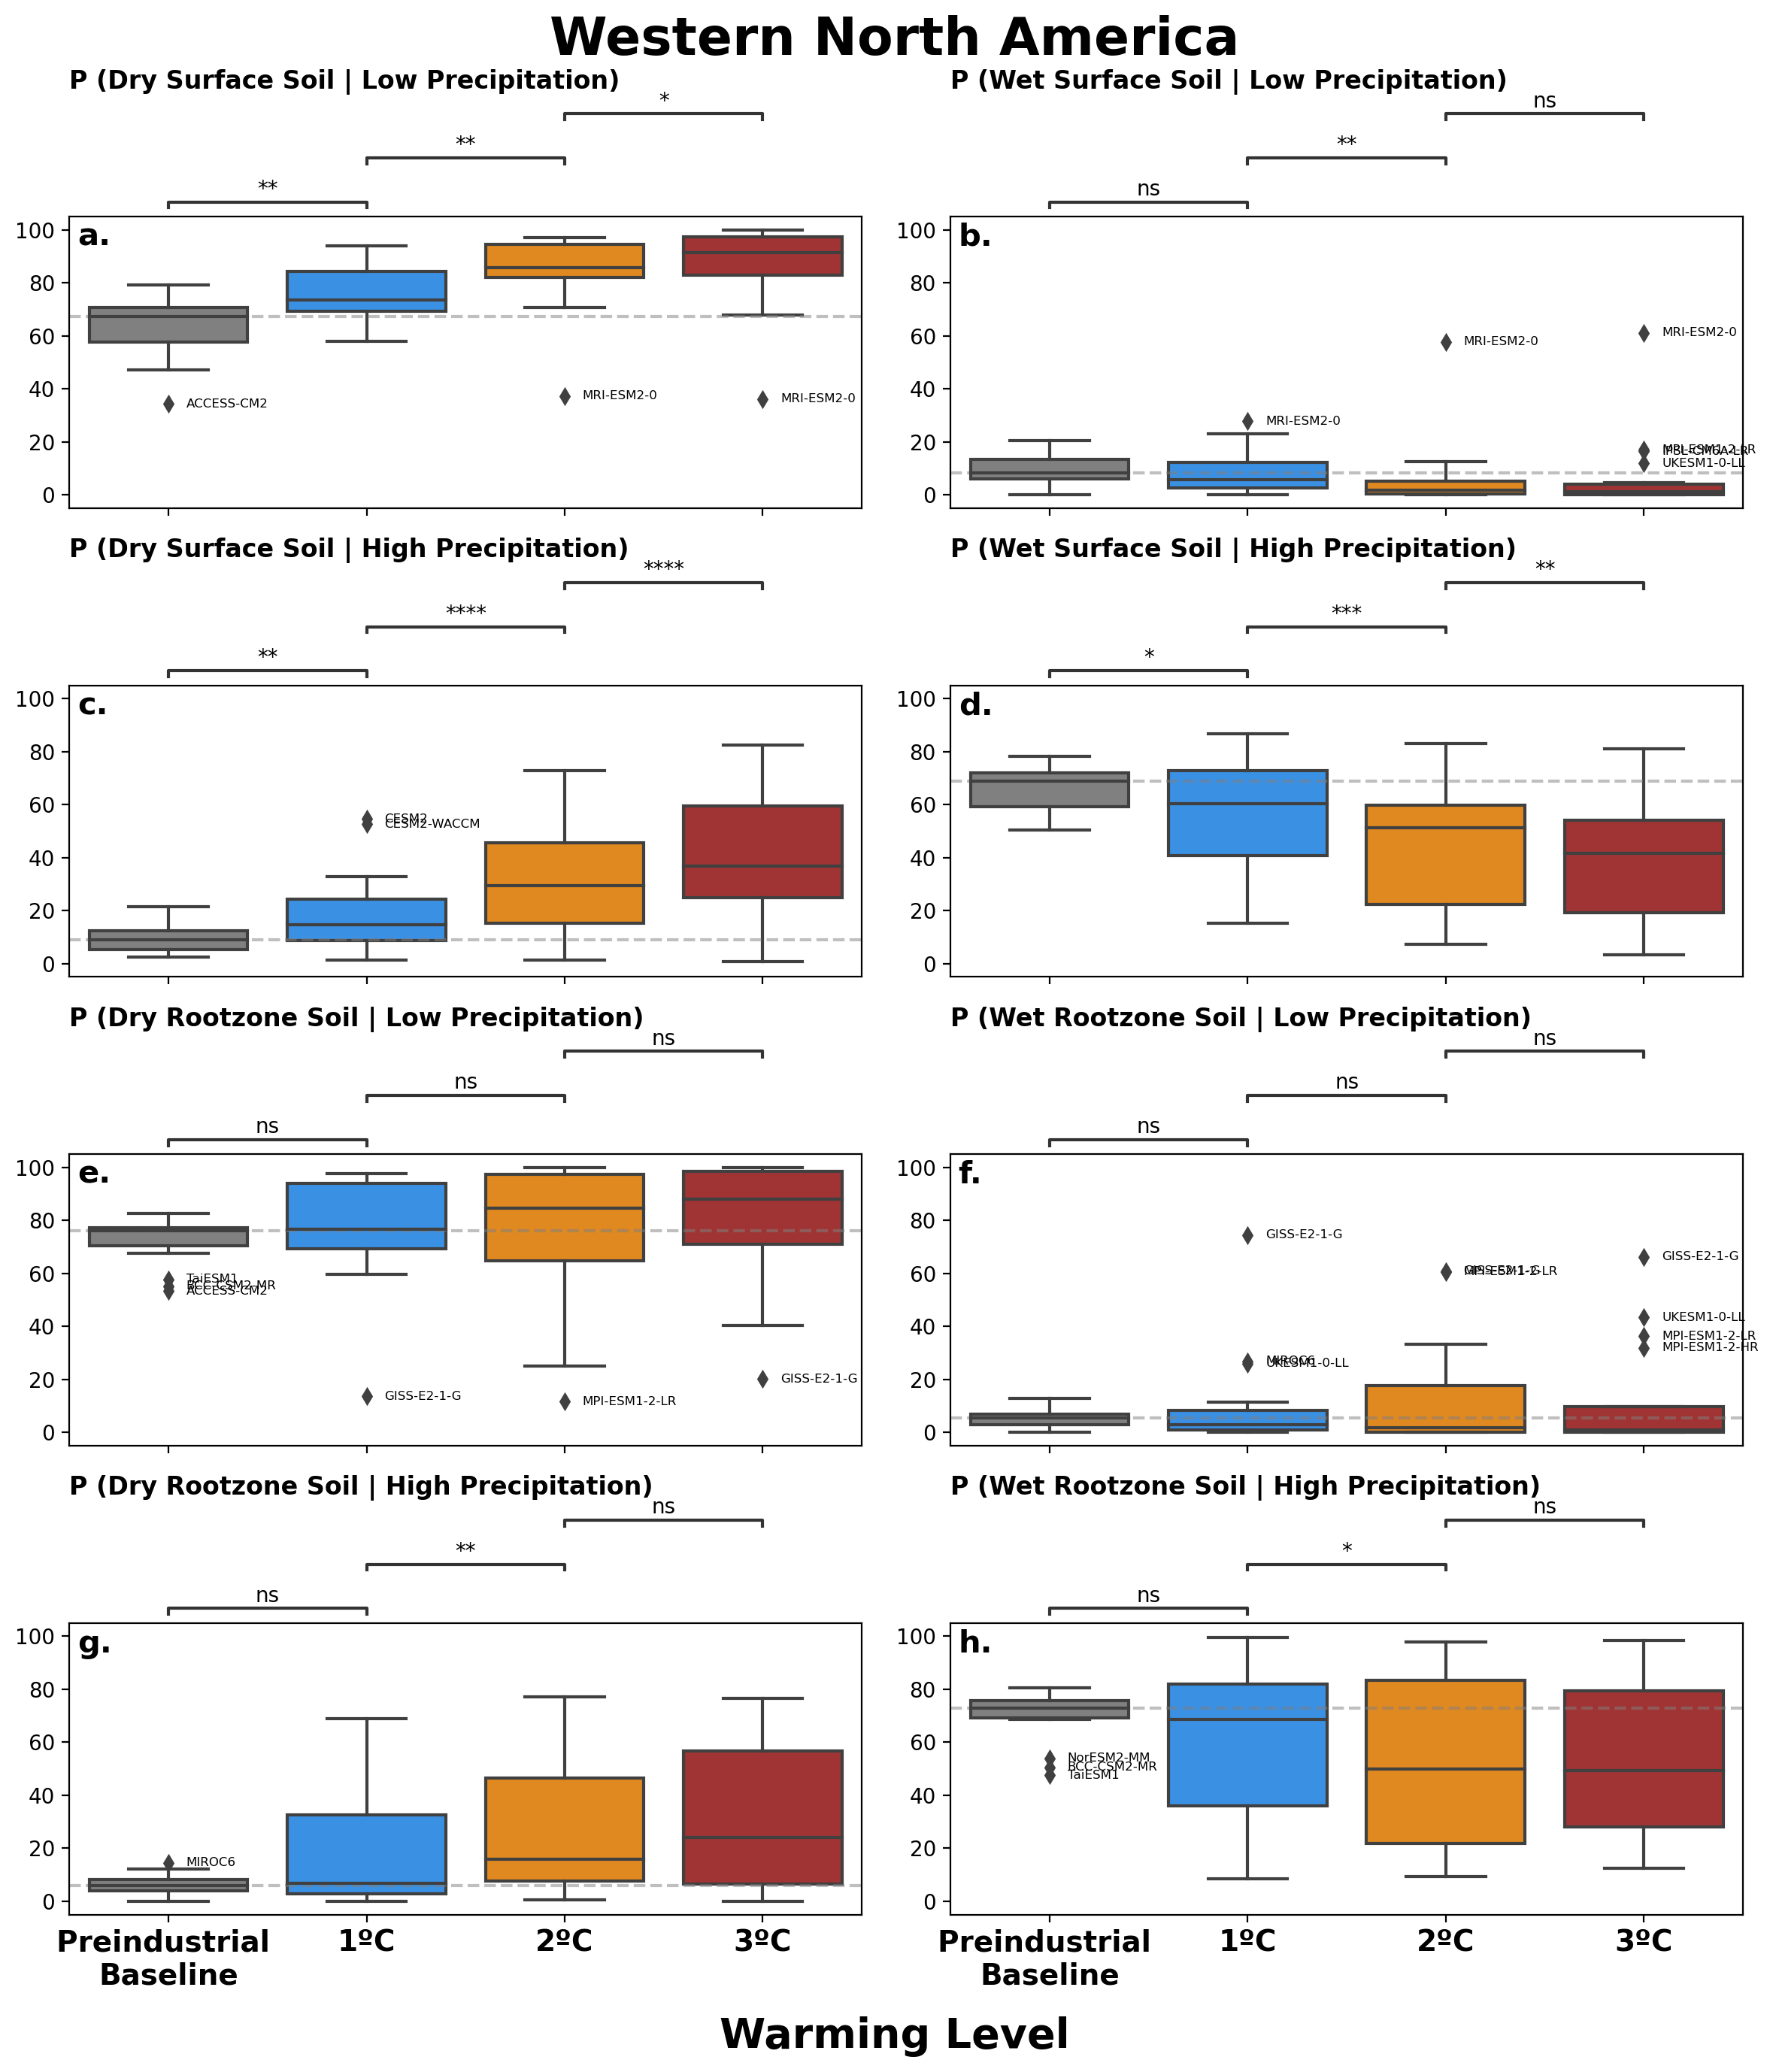

In [277]:
spi_6_WNA_events = {k: relative_events_likelihood['WNA'][k] for k in relative_events_likelihood['WNA'].keys() & spi_1_6}

boxplot_relative_event_likelihood(spi_6_WNA_events, 'WNA', order = spi_1_6, outliers = True)

In [278]:
def percent_change(start_value, final_value):
    
    percent_increase = (final_value - start_value)/start_value * 100
    
    return percent_increase

def multiple_more_likely(start_value, final_value):
    
    if start_value > final_value:
        multiple_more_likely = (start_value / final_value)

    if start_value < final_value:
        multiple_more_likely = (final_value / start_value)

    return multiple_more_likely


### Numbers for Paper

We demonstrate that the same monthly precipitation deficits (25th percentile relative to a preindustrial baseline) at a global warming level of 2ºC increase the probability of both surface and rootzone soil moisture drought by **29\%** in the Mediterranean and **32\%** and **6\%** in Western North America compared to the preindustrial baseline. 

In [279]:
print('**Surface Soil Moisture**')

event_key = 'sm_surface_low_pr_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)

print('Mediterranean increase in the P(low surface soil | low precipitation): ' + str(delta) + '%')

region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)

print('Western North America increase in the P(low surface soil | low precipitation): ' + str(delta) + '%')

print('**Rootzone Soil Moisture**')

event_key = 'sm_200_low_spi_6_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)

print('Mediterranean increase in the P(low rootzone soil | low precipitation): ' + str(delta) + '%')

region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)

print('Western North America increase in the P(low rootzone soil | low precipitation): ' + str(delta) + '%')

**Surface Soil Moisture**
Mediterranean increase in the P(low surface soil | low precipitation): [29.]%
Western North America increase in the P(low surface soil | low precipitation): [32.]%
**Rootzone Soil Moisture**
Mediterranean increase in the P(low rootzone soil | low precipitation): [29.]%
Western North America increase in the P(low rootzone soil | low precipitation): [6.]%


#### Surface Soil
In abstract: Furthermore, the probability of a dry (25th percentile relative to a preindustrial baseline) surface soil moisture month given a high (75th percentile relative to a preindustrial baseline) precipitation month is **6** (Mediterranean) and **3** (Western North America) times more likely in a 2ºC world compared to the preindustrial baseline.


In Discussion: The increased probability of dry soil surface moisture given a wet precipitation month is even larger at 6 and 3 times more likely for the Mediterranean and Western North America, respectively.

In [280]:
print('**Surface Soil Moisture**')

event_key = 'sm_surface_high_pr_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

#delta = np.round(percent_change(baseline, two_degree), 0)
delta = np.round(multiple_more_likely(baseline, two_degree), 1)

print('Mediterranean increase in the P(low surface soil | high precipitation): ' + str(delta) + 'x more likely')

region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
#delta = np.round(percent_change(baseline, two_degree), 0)
delta = np.round(multiple_more_likely(baseline, two_degree), 1)


print('Western North America increase in the P(low surface soil | high precipitation): ' + str(delta) + 'x more likely')

**Surface Soil Moisture**
Mediterranean increase in the P(low surface soil | high precipitation): [6.]x more likely
Western North America increase in the P(low surface soil | high precipitation): [3.3]x more likely


Conversely, the median probability of an anomalously wet surface soil moisture, given a high-precipitation month, is **42\% (Mediterranean) and 36\% (Western North America) less** likely at 2ºC than during the baseline period. 

In [281]:
event_key = 'sm_surface_high_pr_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

delta = np.round(percent_change(baseline, two_degree), 0)
#delta = np.round(multiple_more_likely(baseline, two_degree), 1)

print('Mediterranean change in the P(high surface soil | high precipitation): ' + str(delta) + '%')

region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)
#delta = np.round(multiple_more_likely(baseline, two_degree), 1)


print('Western North America change in the P(high surface soil | high precipitation): ' + str(delta) + '%')

Mediterranean change in the P(high surface soil | high precipitation): [-42.]%
Western North America change in the P(high surface soil | high precipitation): [-26.]%


The probability of a wet rootzone soil moisture during a high-precipitation period in the Mediterranean is down by **87\%** at 2ºC and in Western North America, the probability decreases by **32\%,** relative to baseline. 


In [282]:
event_key = 'sm_200_high_spi_6_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

delta = np.round(percent_change(baseline, two_degree), 0)
#delta = np.round(multiple_more_likely(baseline, two_degree), 1)

print('Mediterranean change in the P(high rootzone soil | high precipitation): ' + str(delta) + '%')

region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
delta = np.round(percent_change(baseline, two_degree), 0)
#delta = np.round(multiple_more_likely(baseline, two_degree), 1)


print('Western North America change in the P(high rootzone soil | high precipitation): ' + str(delta) + '%')

Mediterranean change in the P(high rootzone soil | high precipitation): [-87.]%
Western North America change in the P(high rootzone soil | high precipitation): [-32.]%


For example, the average probability of a dry surface soil moisture event following a low precipitation event increases from **71\%** under preindustrial conditions to **~91\%** with 2ºC of warming (Figure 4a.), a **29\%** increase.

In [283]:
print('**Surface Soil Moisture**')

event_key = 'sm_surface_low_pr_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()[[percentile]]
df

**Surface Soil Moisture**


,,low_percentile
warming_level,variable,
1,mrsos_anom,84.028383
2,mrsos_anom,90.898205
3,mrsos_anom,92.202034
baseline,mrsos_anom,70.606967


In [284]:
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

delta = np.round(percent_change(baseline, two_degree), 0)
print('Mediterranean increase in the P(low surface soil | low precipitation): ' + str(delta) + '%')


Mediterranean increase in the P(low surface soil | low precipitation): [29.]%


During the same low precipitation event, the probability of a wet surface soil moisture month remains low with increased warming, with a median value of **$<1$\%** for 2 and 3ºC of warming (Figure 4b.).

In [285]:
event_key = 'sm_surface_low_pr_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()[[percentile]]
df

,,high_percentile
warming_level,variable,
1,mrsos_anom,2.966102
2,mrsos_anom,0.634921
3,mrsos_anom,0.253807
baseline,mrsos_anom,4.477612


In a warmer world, high precipitation events will be less able to moisten soils in the Mediterranean: the median probability of a wet surface soil moisture event given a high precipitation event decreases from **71\%** in the baseline to **36\%** at 3ºC. 

In [286]:
event_key = 'sm_surface_high_pr_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()[[percentile]]
df

,,high_percentile
warming_level,variable,
1,mrsos_anom,59.701493
2,mrsos_anom,41.509434
3,mrsos_anom,35.897436
baseline,mrsos_anom,71.311475


At 3ºC of warming, the probability that even a high precipitation event will be followed by a dry surface soil moisture event increases **eightfold (from 4\% to 38\%)**, suggesting that rainfall anomalies considered moderately high events in the baseline case will be insufficient to terminate future droughts.

In [287]:
event_key = 'sm_surface_high_pr_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
three_degree = s[str(warming_levels[3])].values

delta = np.round(multiple_more_likely(baseline, three_degree), 1)
print('Mediterranean increase in the P(low surface soil | high precipitation): ' + str(delta) + 'x more likely')

print(s)


Mediterranean increase in the P(low surface soil | high precipitation): [8.4]x more likely
warming_level  variable  
1              mrsos_anom    13.348495
2              mrsos_anom    27.515236
3              mrsos_anom    38.682516
baseline       mrsos_anom     4.585327
Name: low_percentile, dtype: float64


##### WNA

The mean probability of dry surface soil moisture conditions under both low and high monthly precipitation anomalies increases significantly with warming (Figure 8a., c.): dry surface soils are **1.3 and 3.3** times more likely during low- and high-precipitation anomalies, respectively, at 2ºC of warming, a **32\% and 232\%** increase compared to the baseline probability. 

In [288]:
event_key = 'sm_surface_low_pr_events'
percentile = 'low_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

delta = np.round(multiple_more_likely(baseline, two_degree), 1)
print('Western North America increase in the P(low surface soil | low precipitation): ' + str(delta) + 'x more likely')

delta = np.round(percent_change(baseline, two_degree), 0)
print('Western North America increase in the P(low surface soil | low precipitation): ' + str(delta) + '%')

event_key = 'sm_surface_high_pr_events'
percentile = 'low_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

delta = np.round(multiple_more_likely(baseline, two_degree), 1)
print('Western North America increase in the P(low surface soil | high precipitation): ' + str(delta) + 'x more likely')

delta = np.round(percent_change(baseline, two_degree), 0)
print('Western North America increase in the P(low surface soil | high precipitation): ' + str(delta) + '%')



Western North America increase in the P(low surface soil | low precipitation): [1.3]x more likely
Western North America increase in the P(low surface soil | low precipitation): [32.]%
Western North America increase in the P(low surface soil | high precipitation): [3.3]x more likely
Western North America increase in the P(low surface soil | high precipitation): [232.]%


 Similarly, the median probability of wet surface soil moisture conditions decrease by **77\% and 26\%** during these same precipitation months.

In [289]:
event_key = 'sm_surface_low_pr_events'
percentile = 'high_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values


delta = np.round(percent_change(baseline, two_degree), 0)
print('Western North America increase in the P(high surface soil | low precipitation): ' + str(delta) + '%')

event_key = 'sm_surface_high_pr_events'
percentile = 'high_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values


delta = np.round(percent_change(baseline, two_degree), 1)
print('Western North America increase in the P(high surface soil | high precipitation): ' + str(delta) + '%')

Western North America increase in the P(high surface soil | low precipitation): [-77.]%
Western North America increase in the P(high surface soil | high precipitation): [-25.6]%


#### Rootzone
In the rootzone, dry events are all but guaranteed during low precipitation at 2 and 3ºC of warming: the probability of a dry rootzone soil moisture event given a low precipitation event increases from a mean probability of **75\%** during the preindustrial baseline to **96\%** at 2ºC and **98\%** at 3ºC (Figure 4e.).

In [290]:
print('**Rootzone Soil Moisture**')

event_key = 'sm_200_low_spi_6_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()[[percentile]]
df

**Rootzone Soil Moisture**


,,low_percentile
warming_level,variable,
1,mrsol_anom,90.365548
2,mrsol_anom,96.054224
3,mrsol_anom,98.118381
baseline,mrsol_anom,74.658394


At 2 and 3ºC of warming, the region is extremely unlikely **(mean 1.5\% and 0.5\% respectively)** to experience wet rootzone soil moisture during low precipitation periods.

In [291]:
event_key = 'sm_200_low_spi_6_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()[[percentile]]
df

,,high_percentile
warming_level,variable,
1,mrsol_anom,3.064677
2,mrsol_anom,1.466687
3,mrsol_anom,0.514158
baseline,mrsol_anom,3.964734


For rootzone soil moisture, by 2ºC of warming, the probability of a wet rootzone soil moisture event during a high-percentile precipitation event is less than **10\%** for the majority of models, down from **73\%** during the baseline period.

In [193]:
event_key = 'sm_200_high_spi_6_events'
percentile = 'high_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()[[percentile]]
df

,,high_percentile
warming_level,variable,
1,mrsol_anom,40.000000
2,mrsol_anom,9.472422
3,mrsol_anom,3.398058
baseline,mrsol_anom,72.588832


And the probability of a dry rootzone during a high-precipitation event is more than **11 times more likely at 2ºC of warming.**

In [292]:
event_key = 'sm_200_high_spi_6_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values
#delta = np.round(percent_change(baseline, two_degree), 0)
delta = np.round(multiple_more_likely(baseline, two_degree), 1)


print('Mediterranean increase in the P(low rootzone soil | high precipitation): ' + str(delta) + 'x more likely')

Mediterranean increase in the P(low rootzone soil | high precipitation): [11.]x more likely


##### WNA

At 2ºC, the probability of a dry or wet rootzone soil moisture increases by **6\% and decreases by 25\%** relative to the preindustrial baseline. 
[removed from paper because it was redundant]

In [293]:
event_key = 'sm_200_low_spi_6_events'
percentile = 'low_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values


delta = np.round(percent_change(baseline, two_degree), 0)
print('Western North America increase in the P(low surface soil | low precipitation): ' + str(delta) + '%')

##############

event_key = 'sm_200_high_spi_6_events'
percentile = 'high_percentile'
region = 'WNA'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values


delta = np.round(percent_change(baseline, two_degree), 1)
print('Western North America increase in the P(high surface soil | high precipitation): ' + str(delta) + '%')

Western North America increase in the P(low surface soil | low precipitation): [6.]%
Western North America increase in the P(high surface soil | high precipitation): [-25.5]%


## Testing Various Permutations of SPI and rootzone

### SPI 1 Month for surface and 6 months for root zone

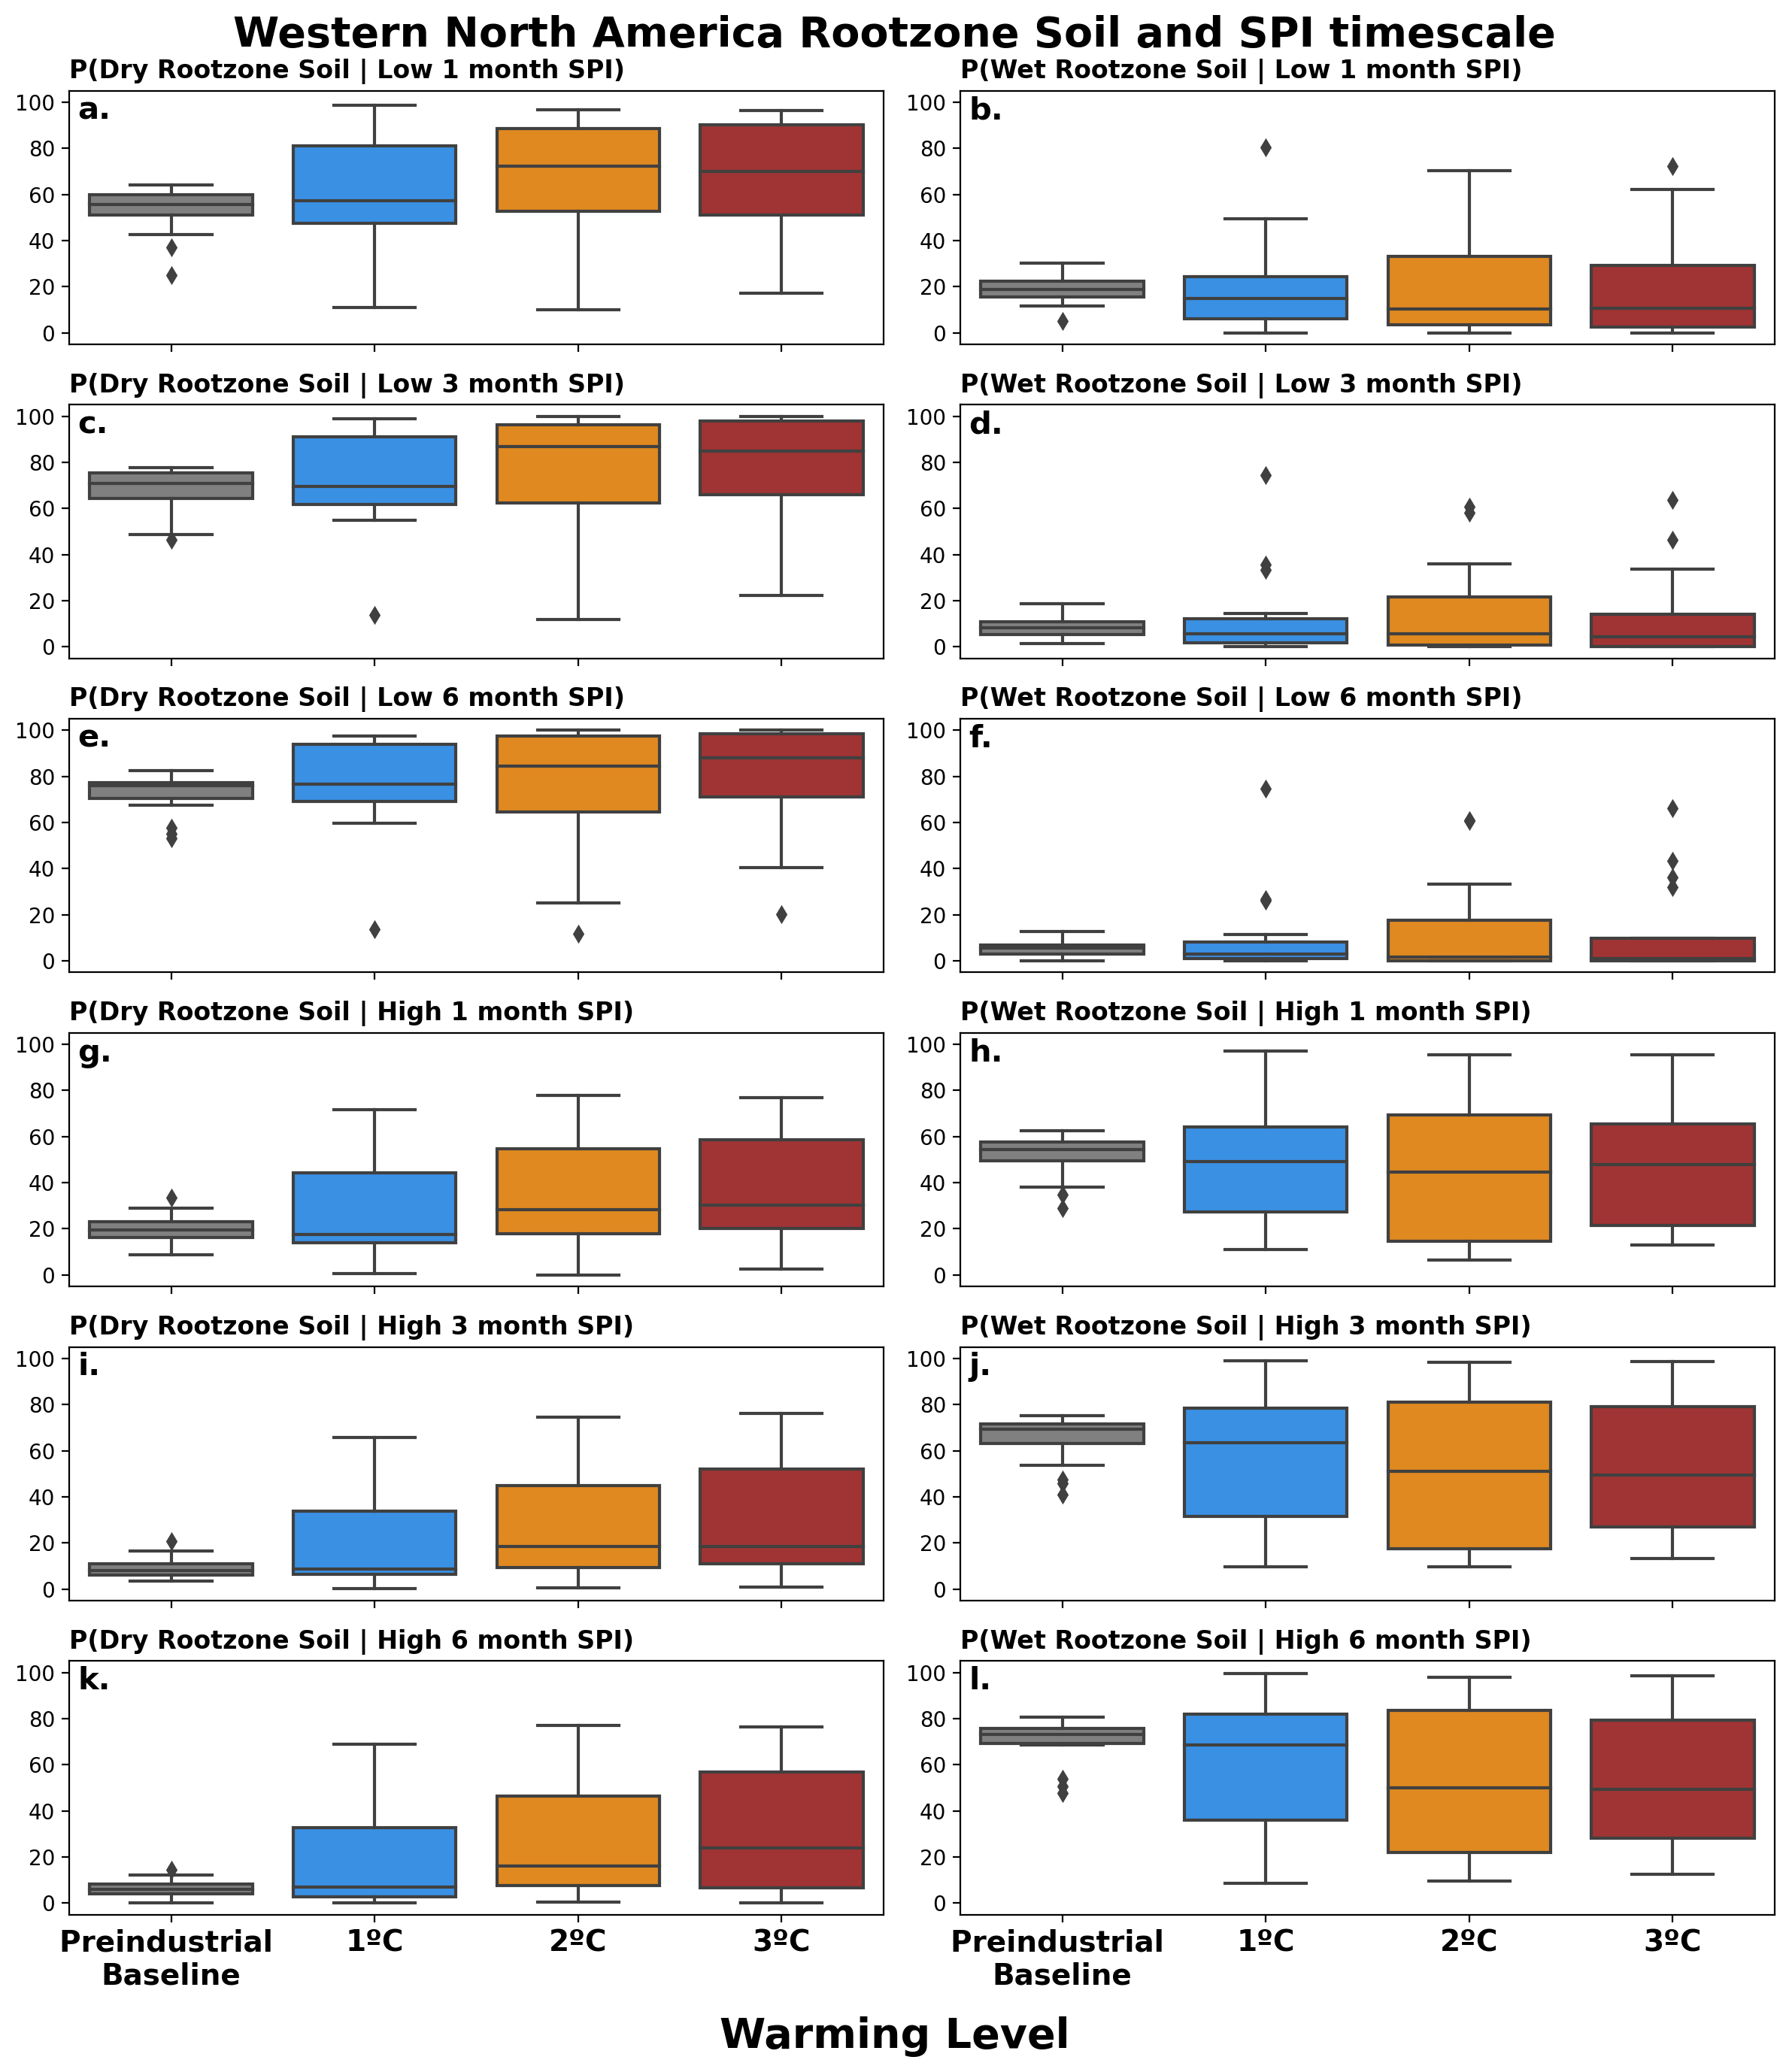

In [294]:
rootzone_spis = ['sm_200_low_spi_1_events', 'sm_200_low_spi_3_events', 'sm_200_low_spi_6_events',
                 'sm_200_high_spi_1_events', 'sm_200_high_spi_3_events', 'sm_200_high_spi_6_events']

#labels = ['Dry 1 month SPI', 'Wet 1 month SPI', 'Dry 3 month SPI', 'Wet 3 month SPI', 'Dry 6 month SPI', 'Wet 6 month SPI'] 



comparing_rootzone_WNA = {k: relative_events_likelihood['WNA'][k] for k in relative_events_likelihood['WNA'].keys() & rootzone_spis}


event_percentile = ['low_percentile','high_percentile']


palette = ['grey', 'dodgerblue', 'darkorange', 'firebrick']

events_likelihood = comparing_rootzone_WNA
    
nrows = len(events_likelihood.keys())
ncols = 2

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharey = False, figsize = [12,14], sharex = True)

for event, row in zip(rootzone_spis, np.arange(0, len(events_likelihood.keys()))):
    for severity, col in zip(event_percentile, [0,1]):
        sns.boxplot(data = events_likelihood[event], y = severity, x = 'warming_level', 
                      ax = ax[row, col], palette = palette)


        ax[row,col].set_xlabel(None)
        ax[row,col].set_ylabel(None)

        ax[row,col].set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')
        #ax[row,col].set_title(severity + ' ' + event)

fig.supxlabel('Warming Level', fontsize = 20, weight = 'bold')
fig.suptitle('Western North America Rootzone Soil and SPI timescale', fontsize = 20, weight = 'bold')


labels = ['P(Dry Rootzone Soil | Low 1 month SPI)', 'P(Wet Rootzone Soil | Low 1 month SPI)', 
          'P(Dry Rootzone Soil | Low 3 month SPI)', 'P(Wet Rootzone Soil | Low 3 month SPI)',
          'P(Dry Rootzone Soil | Low 6 month SPI)', 'P(Wet Rootzone Soil | Low 6 month SPI)',
          'P(Dry Rootzone Soil | High 1 month SPI)','P(Wet Rootzone Soil | High 1 month SPI)',
          'P(Dry Rootzone Soil | High 3 month SPI)','P(Wet Rootzone Soil | High 3 month SPI)',
          'P(Dry Rootzone Soil | High 6 month SPI)','P(Wet Rootzone Soil | High 6 month SPI)']

for axes, i, label in zip(ax.flat,np.arange(12), labels) :
    # Subplot lettering from kevin s
    axes.text(0.01,0.98,string.ascii_letters[i]+'.',
            transform=axes.transAxes,ha='left',va='top',
            fontsize=15,fontweight='bold',
            bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
    axes.set_ylim(-5,105)
    axes.set_title(label, loc = 'left', weight = 'bold')

plt.tight_layout()

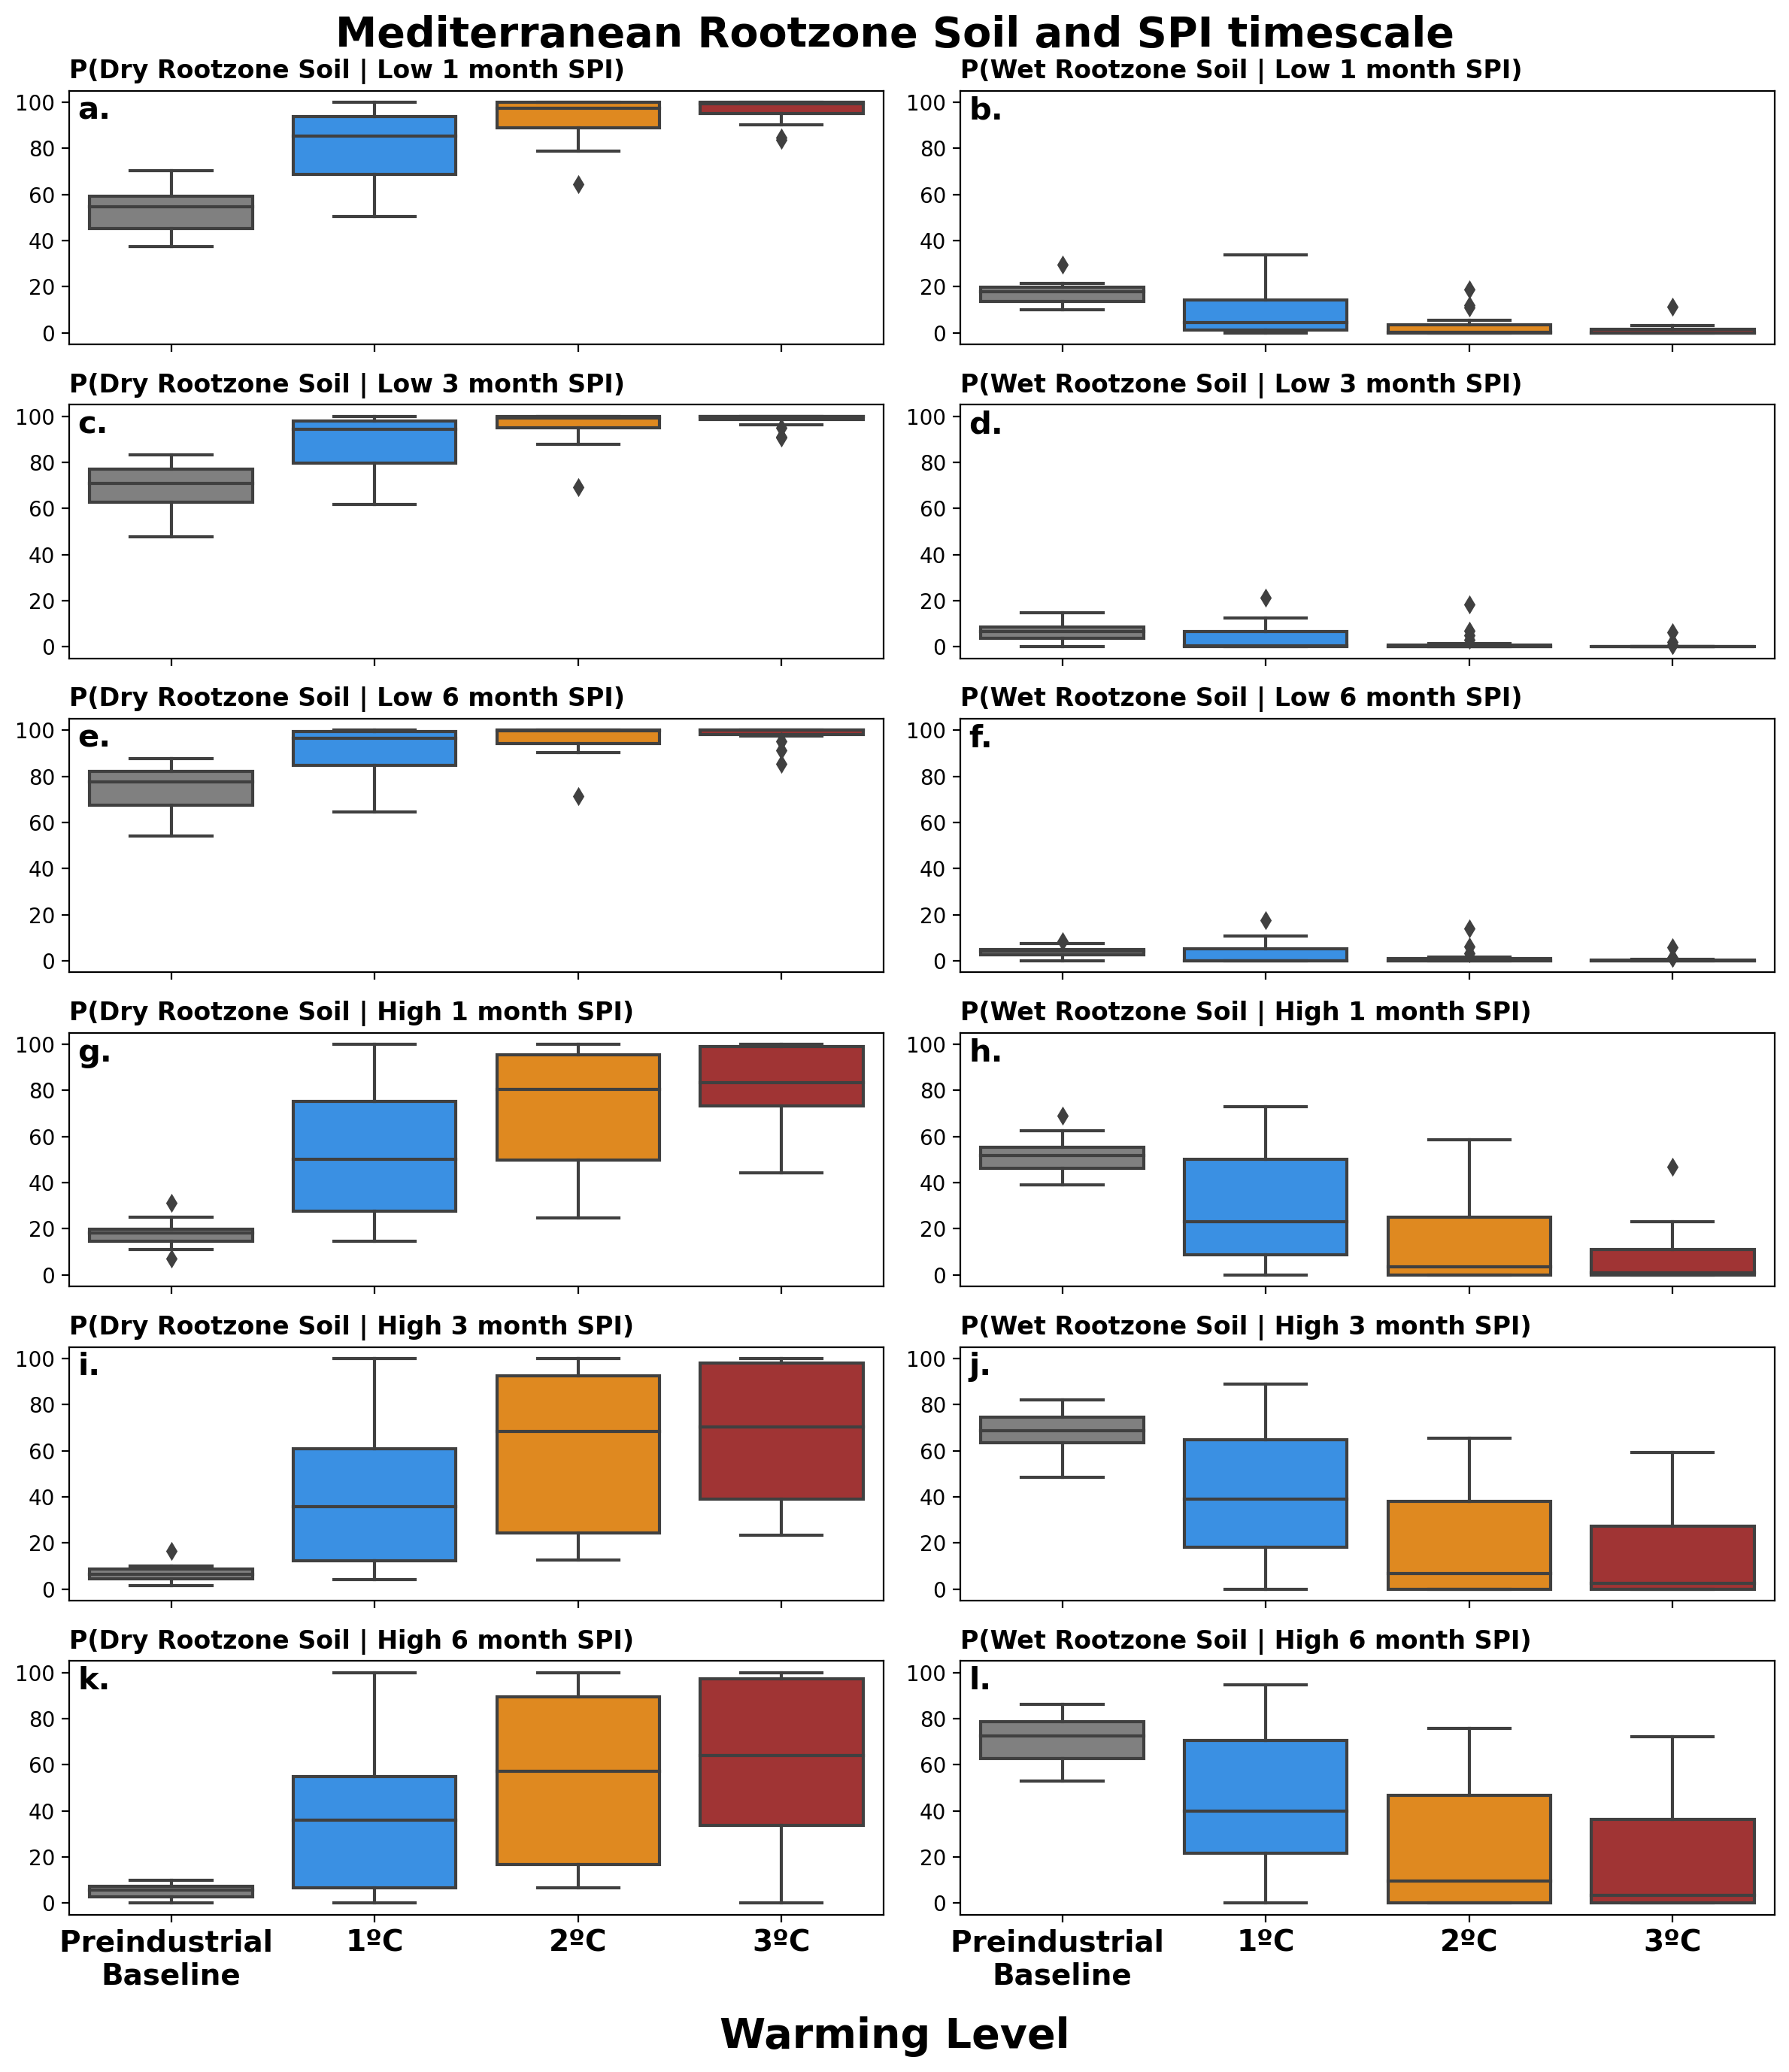

In [295]:
rootzone_spis = ['sm_200_low_spi_1_events', 'sm_200_low_spi_3_events', 'sm_200_low_spi_6_events',
                 'sm_200_high_spi_1_events', 'sm_200_high_spi_3_events', 'sm_200_high_spi_6_events']

#labels = ['Dry 1 month SPI', 'Wet 1 month SPI', 'Dry 3 month SPI', 'Wet 3 month SPI', 'Dry 6 month SPI', 'Wet 6 month SPI'] 



comparing_rootzone_MED = {k: relative_events_likelihood['MED'][k] for k in relative_events_likelihood['MED'].keys() & rootzone_spis}


event_percentile = ['low_percentile','high_percentile']


palette = ['grey', 'dodgerblue', 'darkorange', 'firebrick']

events_likelihood = comparing_rootzone_MED
    
nrows = len(events_likelihood.keys())
ncols = 2

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharey = False, figsize = [12,14], sharex = True)

for event, row in zip(rootzone_spis, np.arange(0, len(events_likelihood.keys()))):
    for severity, col in zip(event_percentile, [0,1]):
        sns.boxplot(data = events_likelihood[event], y = severity, x = 'warming_level', 
                      ax = ax[row, col], palette = palette)


        ax[row,col].set_xlabel(None)
        ax[row,col].set_ylabel(None)

        ax[row,col].set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')
        #ax[row,col].set_title(severity + ' ' + event)

fig.supxlabel('Warming Level', fontsize = 20, weight = 'bold')
fig.suptitle('Mediterranean Rootzone Soil and SPI timescale', fontsize = 20, weight = 'bold')


labels = ['P(Dry Rootzone Soil | Low 1 month SPI)', 'P(Wet Rootzone Soil | Low 1 month SPI)', 
          'P(Dry Rootzone Soil | Low 3 month SPI)', 'P(Wet Rootzone Soil | Low 3 month SPI)',
          'P(Dry Rootzone Soil | Low 6 month SPI)', 'P(Wet Rootzone Soil | Low 6 month SPI)',
          'P(Dry Rootzone Soil | High 1 month SPI)','P(Wet Rootzone Soil | High 1 month SPI)',
          'P(Dry Rootzone Soil | High 3 month SPI)','P(Wet Rootzone Soil | High 3 month SPI)',
          'P(Dry Rootzone Soil | High 6 month SPI)','P(Wet Rootzone Soil | High 6 month SPI)']

for axes, i, label in zip(ax.flat,np.arange(12), labels) :
    # Subplot lettering from kevin s
    axes.text(0.01,0.98,string.ascii_letters[i]+'.',
            transform=axes.transAxes,ha='left',va='top',
            fontsize=15,fontweight='bold',
            bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
    axes.set_ylim(-5,105)
    axes.set_title(label, loc = 'left', weight = 'bold')

plt.tight_layout()

## Looking at 'normal' conditional likelihoods

In [296]:
## new version (with 'normal' events >2th and <75th percentiles)

precip_spi_1 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v3/precip_spi_1.csv')
precip_spi_3 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v3/precip_spi_3.csv')
precip_spi_6 = pd.read_csv('~/precip-events/exported_data/events/precip_spi_v3/precip_spi_6.csv')

In [297]:
## new version with 'normal' events:

relative_events_likelihood = dict()

for region in regions: 
    relative_events_likelihood[region] = ({
        'sm_surface_low_pr_events' : get_event_likelihood(models = models, response_variable = 'mrsos_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'low') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_surface_high_pr_events' : get_event_likelihood(models = models, response_variable = 'mrsos_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'high') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_surface_normal_pr_events': get_event_likelihood(models = models, response_variable = 'mrsos_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'normal') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_1_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'low') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_1_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'high') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_normal_spi_1_events': get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_1[(precip_spi_1.high_or_low == 'normal') & (precip_spi_1.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_3_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_3[(precip_spi_3.high_or_low == 'low') & (precip_spi_3.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_3_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_3[(precip_spi_3.high_or_low == 'high') & (precip_spi_3.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_normal_spi_3_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_3[(precip_spi_3.high_or_low == 'normal') & (precip_spi_3.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_low_spi_6_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_6[(precip_spi_6.high_or_low == 'low') & (precip_spi_6.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_high_spi_6_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_6[(precip_spi_6.high_or_low == 'high') & (precip_spi_6.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region]) , 
        'sm_200_normal_spi_6_events' : get_event_likelihood(models = models, response_variable = 'mrsol_anom', 
                                                      precip_events_pd = precip_spi_6[(precip_spi_6.high_or_low == 'normal') & (precip_spi_6.region == region)], 
                                                      dictionary_of_models_xr = model_anoms[region])  
    })

In [298]:
def boxplot_relative_normal_event_likelihood(dictionary, region, order = None, normal = False):

    events_likelihood = dictionary
    event_percentile = ['low_percentile','high_percentile']
    
    palette = ['grey', 'dodgerblue', 'darkorange', 'firebrick']
    
    nrows = len(events_likelihood.keys())
    ncols = 2
    
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharey = False, figsize = [14,10], sharex = True)
    
    if order is None:
        event_keys = events_likelihood.keys()
        
    if order is not None:
        event_keys = order
    
    ax[0,0].set_title('P (Dry Surface Soil | Normal Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[0,1].set_title('P (Wet Surface Soil | Normal Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    
    ax[1,0].set_title('P (Dry Rootzone Soil | Normal Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')
    ax[1,1].set_title('P (Wet Rootzone Soil | Normal Precipitation)' + '\n' + '\n' + '\n' + '\n', loc = 'left', weight = 'bold')

    for axes, i in zip(ax.flat,np.arange(8)) :
        # Subplot lettering from kevin s
        axes.text(0.01,0.98,string.ascii_letters[i]+'.',
                transform=axes.transAxes,ha='left',va='top',
                fontsize=15,fontweight='bold',
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
        
        axes.set_ylim(-5, 105)

    if region is 'MED':
        fig.suptitle('Mediterranean', fontsize = 25, weight = 'bold')
    
    if region is 'WNA':
        fig.suptitle('Western North America', fontsize = 25, weight = 'bold')
    
    for event, row in zip(event_keys, np.arange(0, len(events_likelihood.keys()))):
        for severity, col in zip(event_percentile, [0,1]):
            
            data = events_likelihood[event]
            y = severity
            x = 'warming_level'
            
            sns.boxplot(data = data, y = y, x = x, ax = ax[row, col], 
                        palette = palette)
        
            pairs=[("baseline", "1"), ("1", "2"), ("2", "3")]

            ax[row,col].axhline(y = data[data.warming_level == 'baseline'][severity].median(), 
                                color = 'grey', alpha = 0.5, linestyle = '--') 

            ax[row,col].set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')

            ax[row,col].set_xlabel(None)
            ax[row,col].set_ylabel(None)
            
            annotator = Annotator(ax[row, col], pairs, data=data, x=x, y=y)
            annotator.configure(test='Wilcoxon', text_format='star', loc='outside', verbose = 0)
            annotator.apply_and_annotate()
        
                        ## FOR TESTING
            #ax[row, col].set_ylabel(severity + '|' + event)
    
        
    fig.supxlabel('Warming Level', fontsize = 20, weight = 'bold')
        
    plt.tight_layout()
    if normal == False:
        plt.savefig('figures/' + region + '_conditional_likelihood.png', dpi = 300, format = 'png')
    if normal == True:
        plt.savefig('figures/' + region + '_normal_conditional_likelihood.png', dpi = 300, format = 'png')


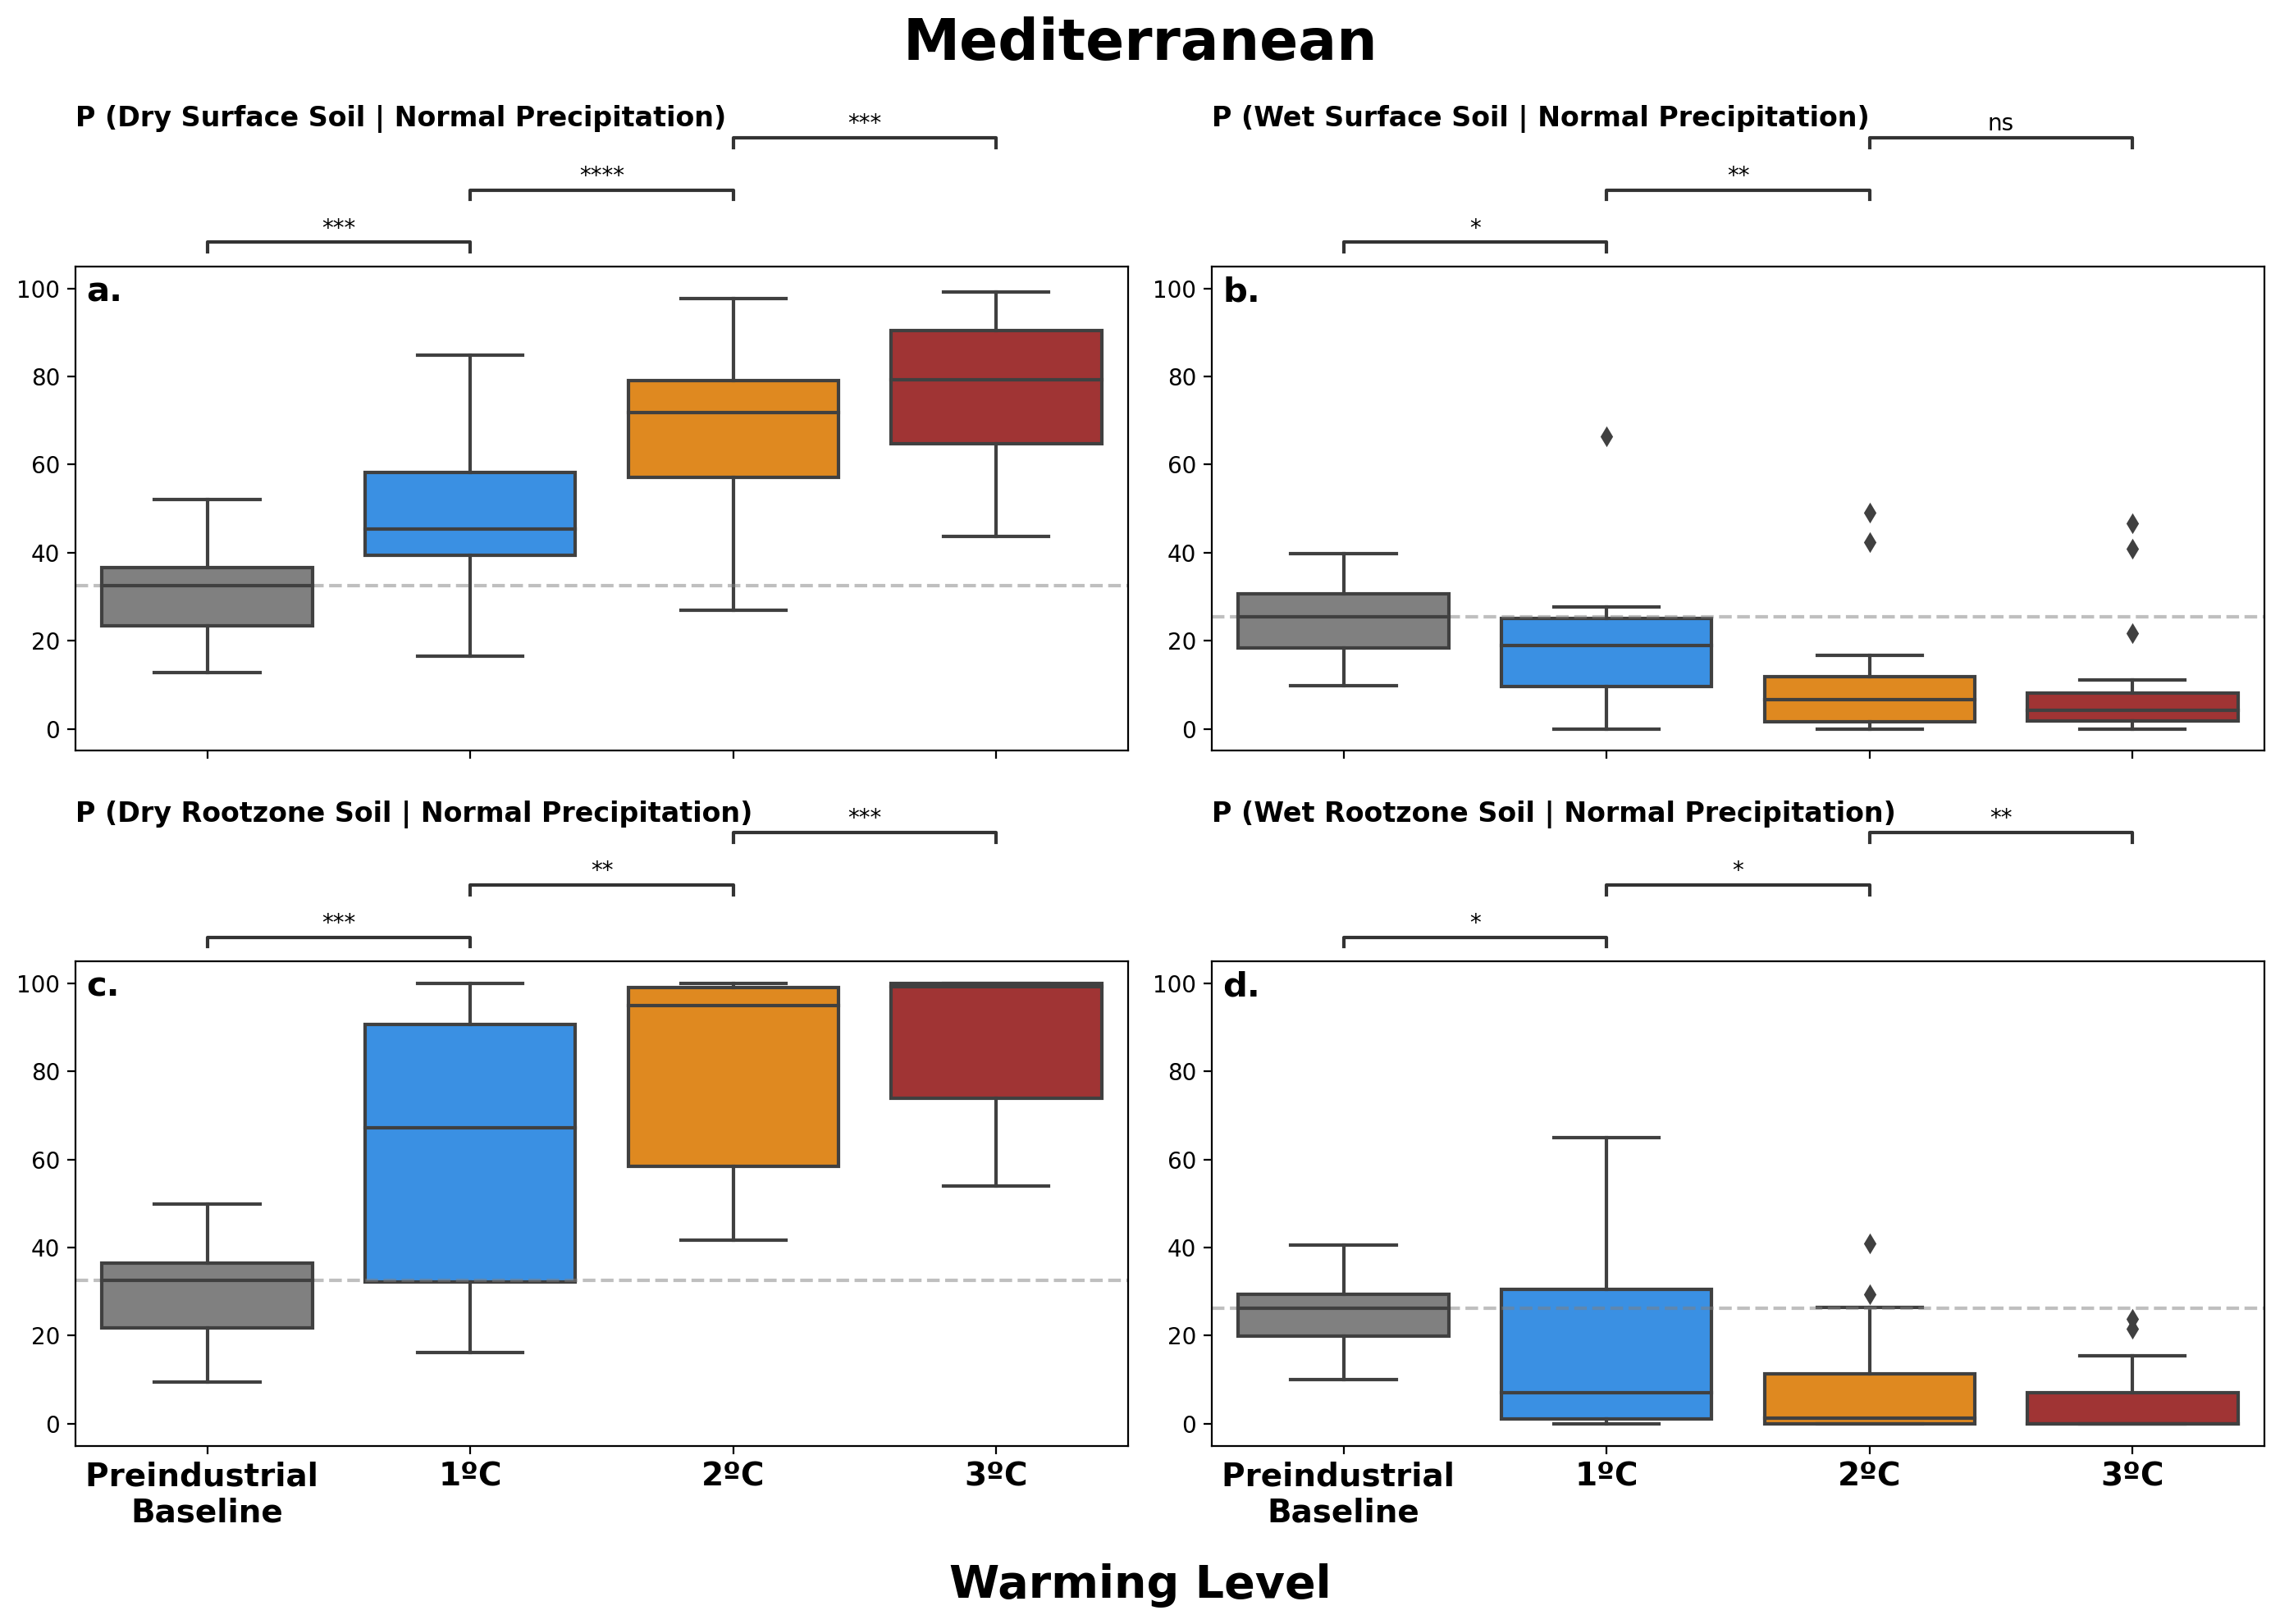

In [299]:
normal_spi_6 = ['sm_surface_normal_pr_events', 'sm_200_normal_spi_6_events']
normal_spi_6_MED_events = {k: relative_events_likelihood['MED'][k] for k in relative_events_likelihood['MED'].keys() & normal_spi_6}
boxplot_relative_normal_event_likelihood(normal_spi_6_MED_events, 'MED', order = normal_spi_6, normal = True)

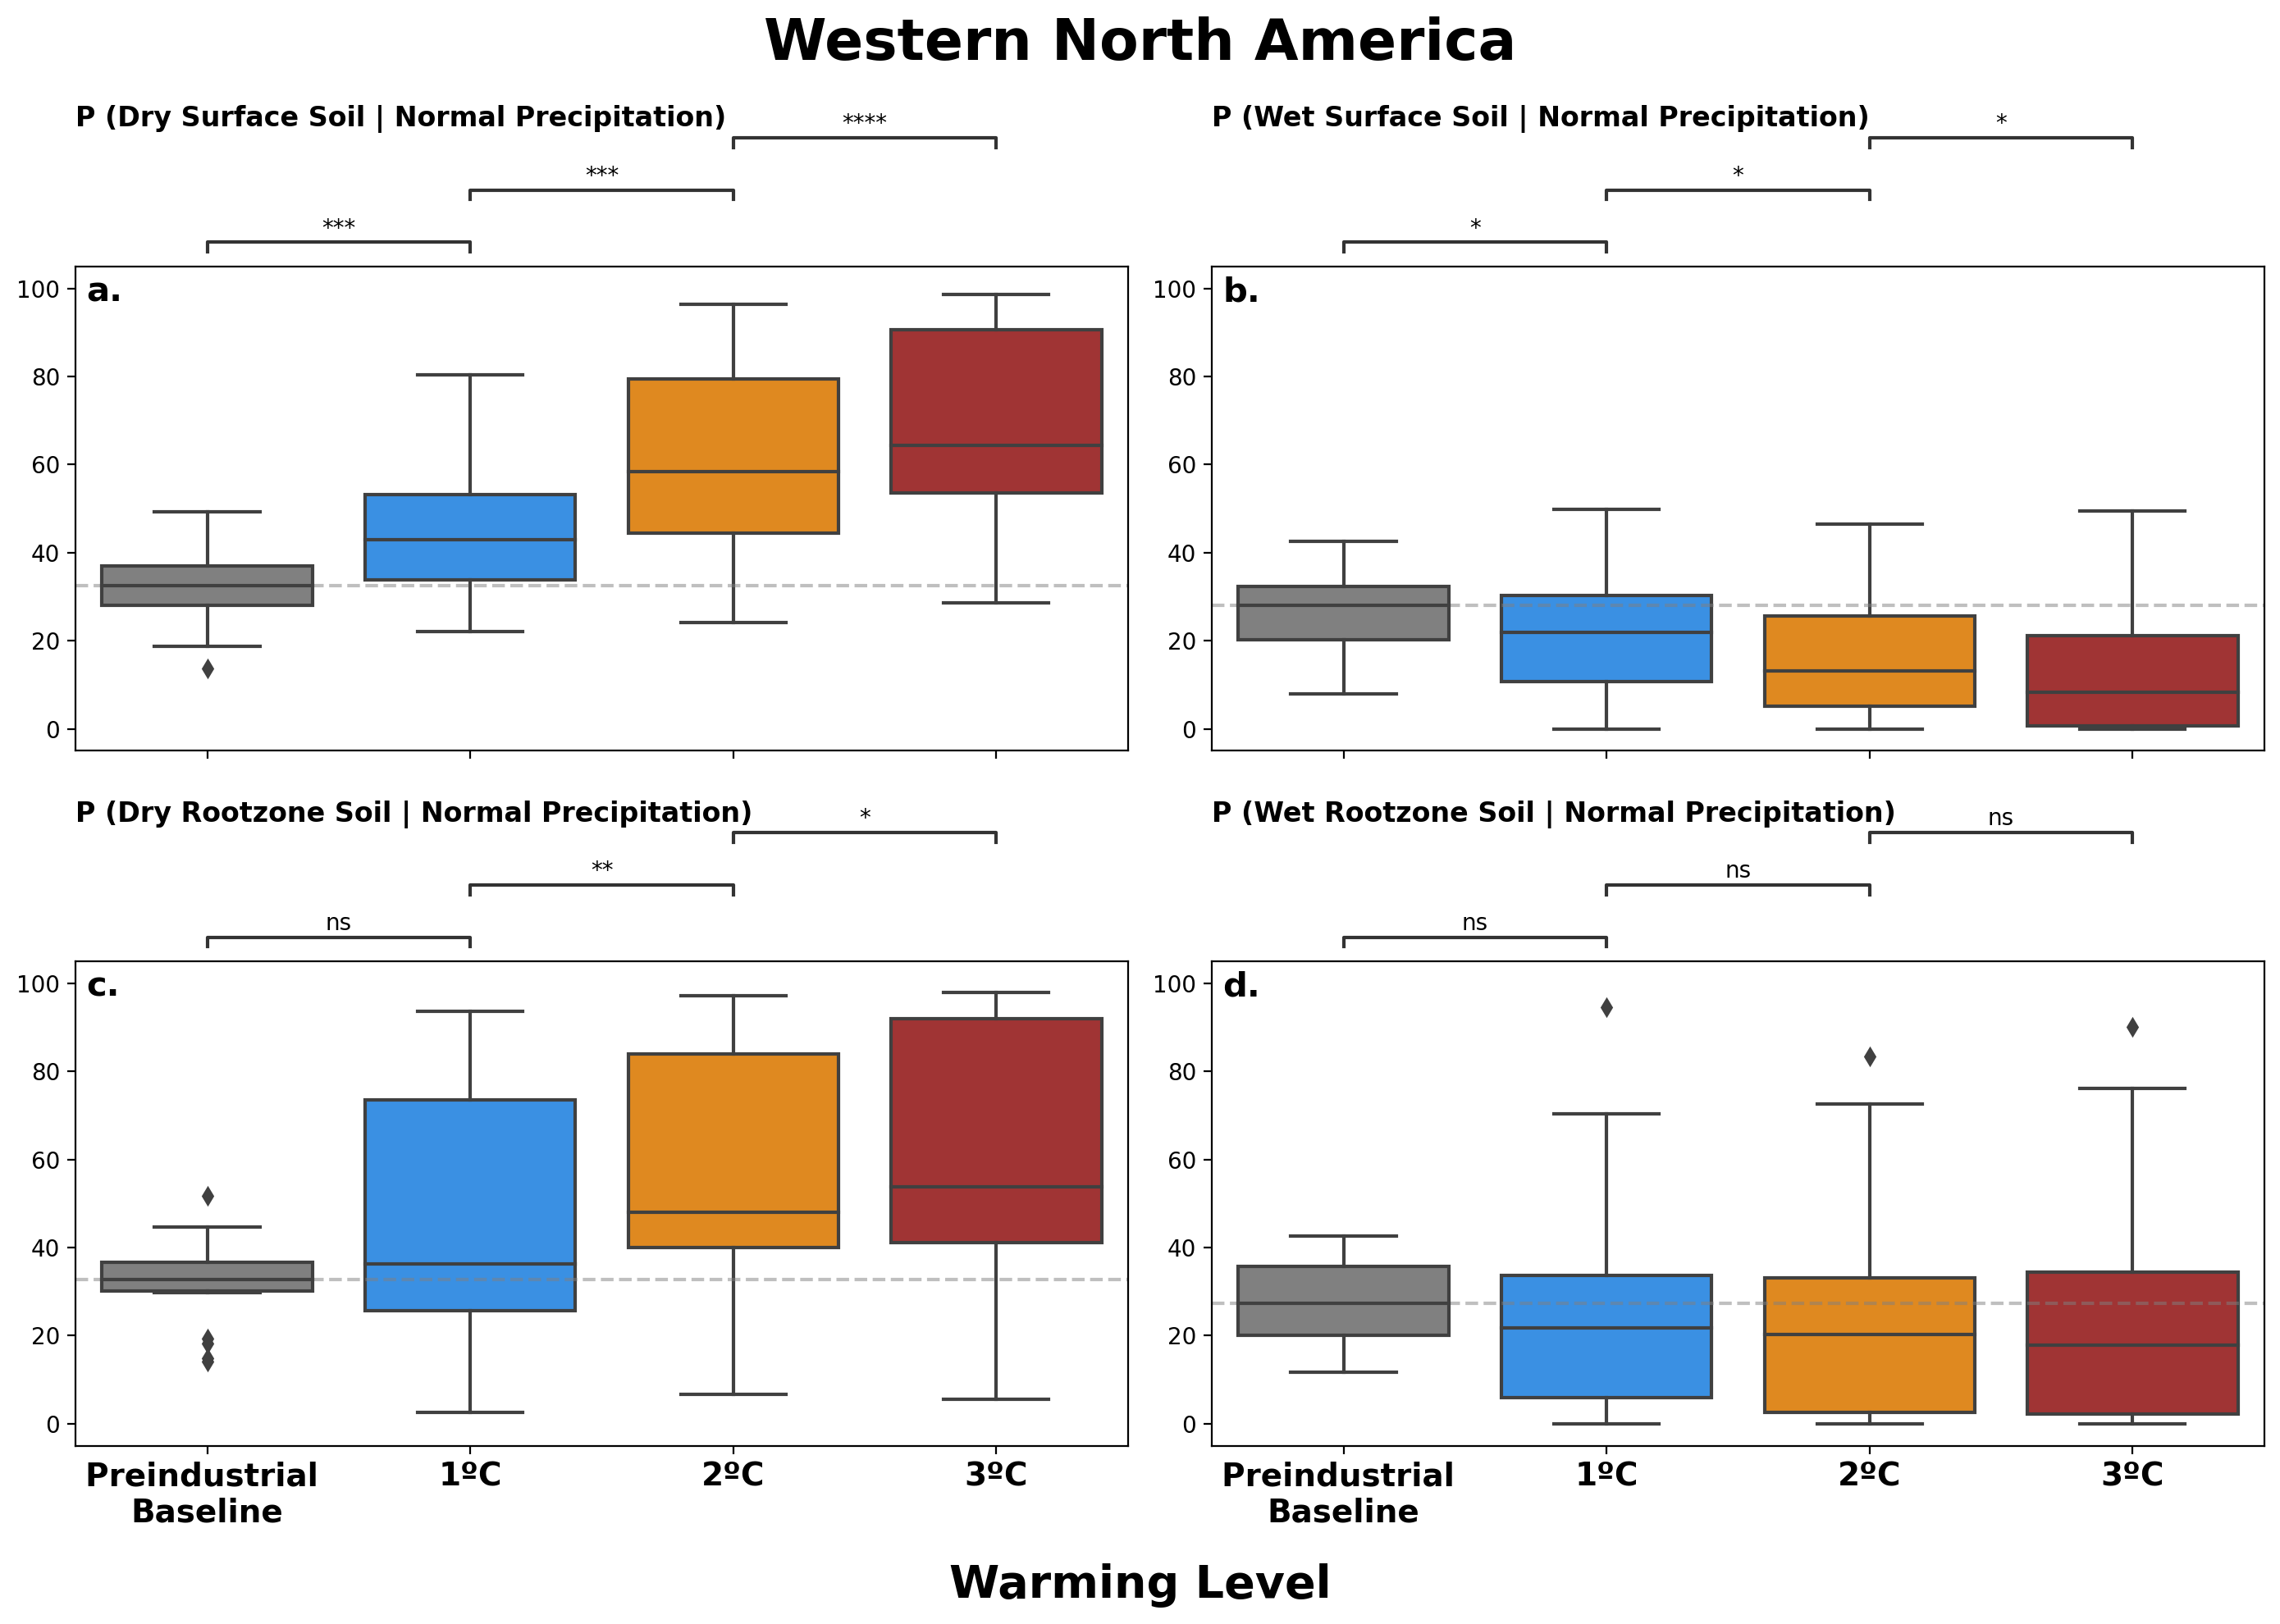

In [300]:
normal_spi_6 = ['sm_surface_normal_pr_events', 'sm_200_normal_spi_6_events']
normal_spi_6_WNA_events = {k: relative_events_likelihood['WNA'][k] for k in relative_events_likelihood['MED'].keys() & normal_spi_6}
boxplot_relative_normal_event_likelihood(normal_spi_6_WNA_events, 'WNA', order = normal_spi_6, normal = True)

In [313]:
event_key = 'sm_200_normal_spi_6_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()[[percentile]]
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

#delta = np.round(percent_change(baseline, two_degree), 0)
delta = np.round(multiple_more_likely(baseline, two_degree), 1)

print('Mediterranean change in the P(low rootzone soil | normal precipitation): ' + str(delta) + 'x more likely')

event_key = 'sm_surface_normal_pr_events'
percentile = 'low_percentile'
region = 'MED'

df = relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).median()[[percentile]]
s = df[percentile]
baseline = s[warming_levels[0]].values
two_degree = s[str(warming_levels[2])].values

#delta = np.round(percent_change(baseline, two_degree), 0)
delta = np.round(multiple_more_likely(baseline, two_degree), 1)

print('Mediterranean change in the P(low rootzone soil | normal precipitation): ' + str(delta) + 'x more likely')

Mediterranean change in the P(low rootzone soil | normal precipitation): [2.9]x more likely
Mediterranean change in the P(low rootzone soil | normal precipitation): [2.2]x more likely


#### Single boxplot relative likelihood

In [66]:
def boxplot_relative_event_likelihood(dictionary, region, event, percentile = 'low_percentile'):

    events_likelihood = dictionary[region]
    
    palette = ['grey', 'dodgerblue', 'darkorange', 'firebrick']
    
    fig, ax = plt.subplots(1, figsize = (8,5))
     
    data = events_likelihood[event]
    y = percentile
    x = 'warming_level'

    sns.boxplot(data = data, y = y, x = x, ax = ax, 
                palette = palette)

    pairs=[("baseline", "1"), ("1", "2"), ("2", "3")]

    annotator = Annotator(ax, pairs, data=data, x=x, y=y)
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    ax.set_xlabel(None)
    ax.set_ylabel(None)
                ## FOR TESTING
    #ax[row, col].set_ylabel(severity + '|' + event)

    ax.set_xticklabels(['Preindustrial \nBaseline', '1ºC', '2ºC', '3ºC'], fontsize = 14, weight = 'bold')
        
        
    plt.tight_layout()
    
    plt.savefig('figures/' + region + '_' + percentile  + '_' + event + '_relative_event_likelihood.png', dpi = 300, format = 'png')


In [67]:
relative_events_likelihood['MED'].keys()

dict_keys(['sm_surface_low_pr_events', 'sm_surface_high_pr_events', 'sm_surface_normal_pr_events', 'sm_200_low_spi_1_events', 'sm_200_high_spi_1_events', 'sm_200_normal_spi_1_events', 'sm_200_low_spi_3_events', 'sm_200_high_spi_3_events', 'sm_200_normal_spi_3_events', 'sm_200_low_spi_6_events', 'sm_200_high_spi_6_events', 'sm_200_normal_spi_6_events'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. 1: Wilcoxon test (paired samples), P_val:5.341e-05 Stat=6.000e+00
1 vs. 2: Wilcoxon test (paired samples), P_val:3.357e-04 Stat=1.300e+01
2 vs. 3: Wilcoxon test (paired samples), P_val:1.964e-04 Stat=0.000e+00


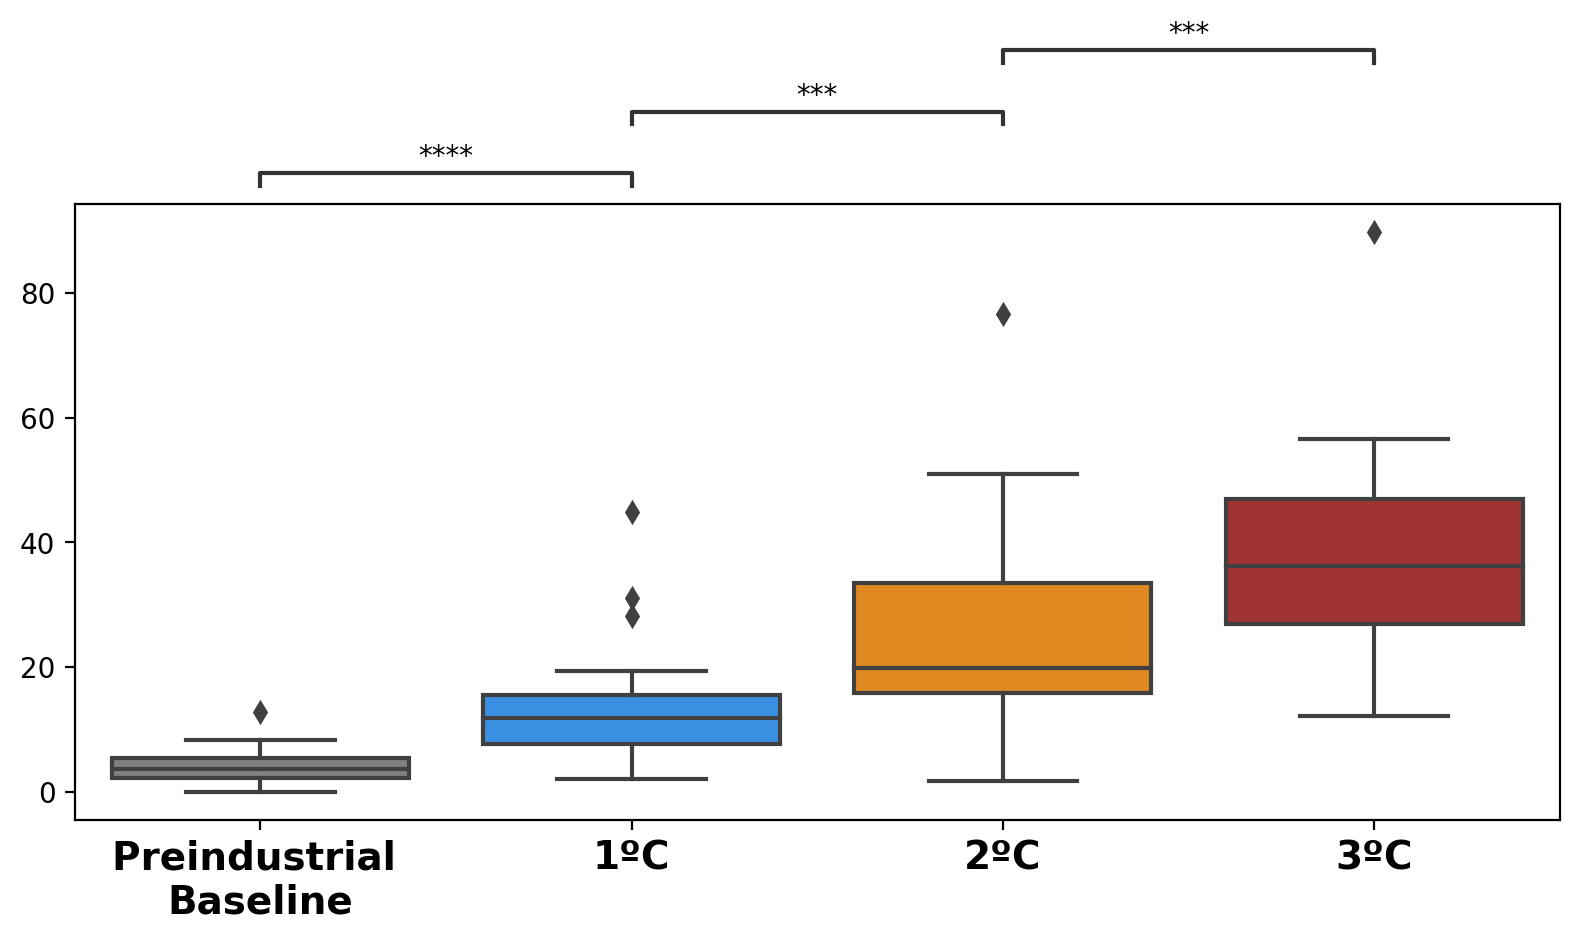

In [68]:
region = 'MED'
event = 'sm_surface_high_pr_events'

boxplot_relative_event_likelihood(relative_events_likelihood, region, event, percentile = 'low_percentile')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. 1: Wilcoxon test (paired samples), P_val:5.341e-05 Stat=6.000e+00
1 vs. 2: Wilcoxon test (paired samples), P_val:1.370e-03 Stat=1.200e+01
2 vs. 3: Wilcoxon test (paired samples), P_val:3.090e-03 Stat=1.400e+01


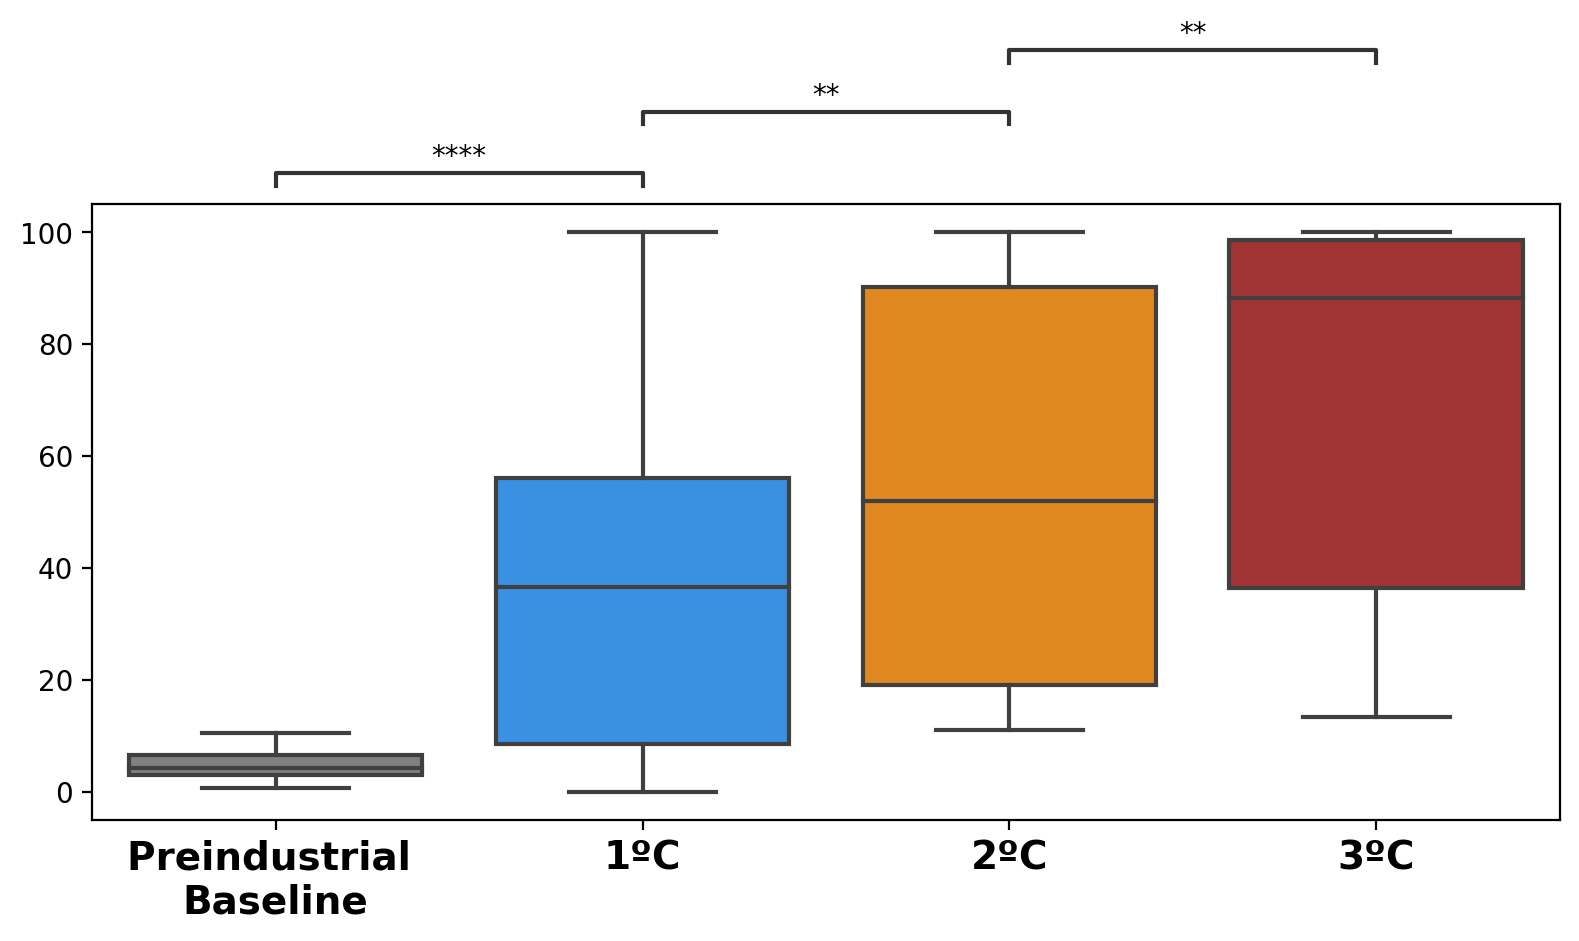

In [69]:
region = 'MED'
event = 'sm_200_high_spi_6_events'

boxplot_relative_event_likelihood(relative_events_likelihood, region, event, percentile = 'low_percentile')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. 1: Wilcoxon test (paired samples), P_val:7.145e-03 Stat=3.000e+01
1 vs. 2: Wilcoxon test (paired samples), P_val:1.259e-04 Stat=9.000e+00
2 vs. 3: Wilcoxon test (paired samples), P_val:3.815e-05 Stat=5.000e+00


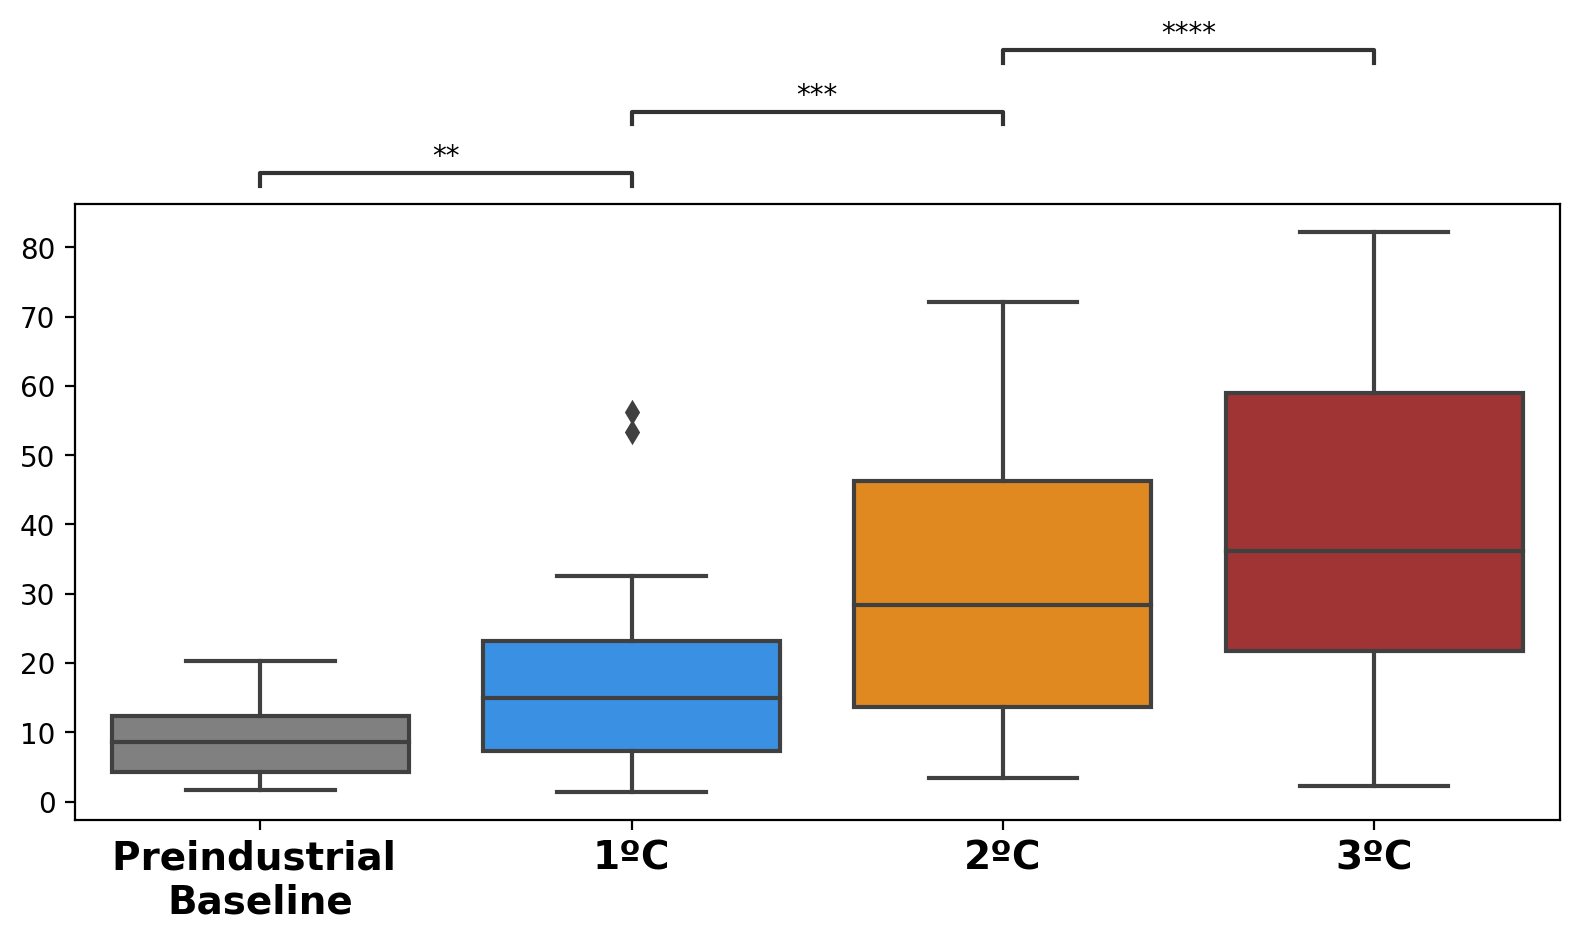

In [70]:
region = 'WNA'
event = 'sm_surface_high_pr_events'

boxplot_relative_event_likelihood(relative_events_likelihood, region, event, percentile = 'low_percentile')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. 1: Wilcoxon test (paired samples), P_val:6.419e-02 Stat=4.300e+01
1 vs. 2: Wilcoxon test (paired samples), P_val:2.022e-03 Stat=2.200e+01
2 vs. 3: Wilcoxon test (paired samples), P_val:7.086e-01 Stat=8.500e+01


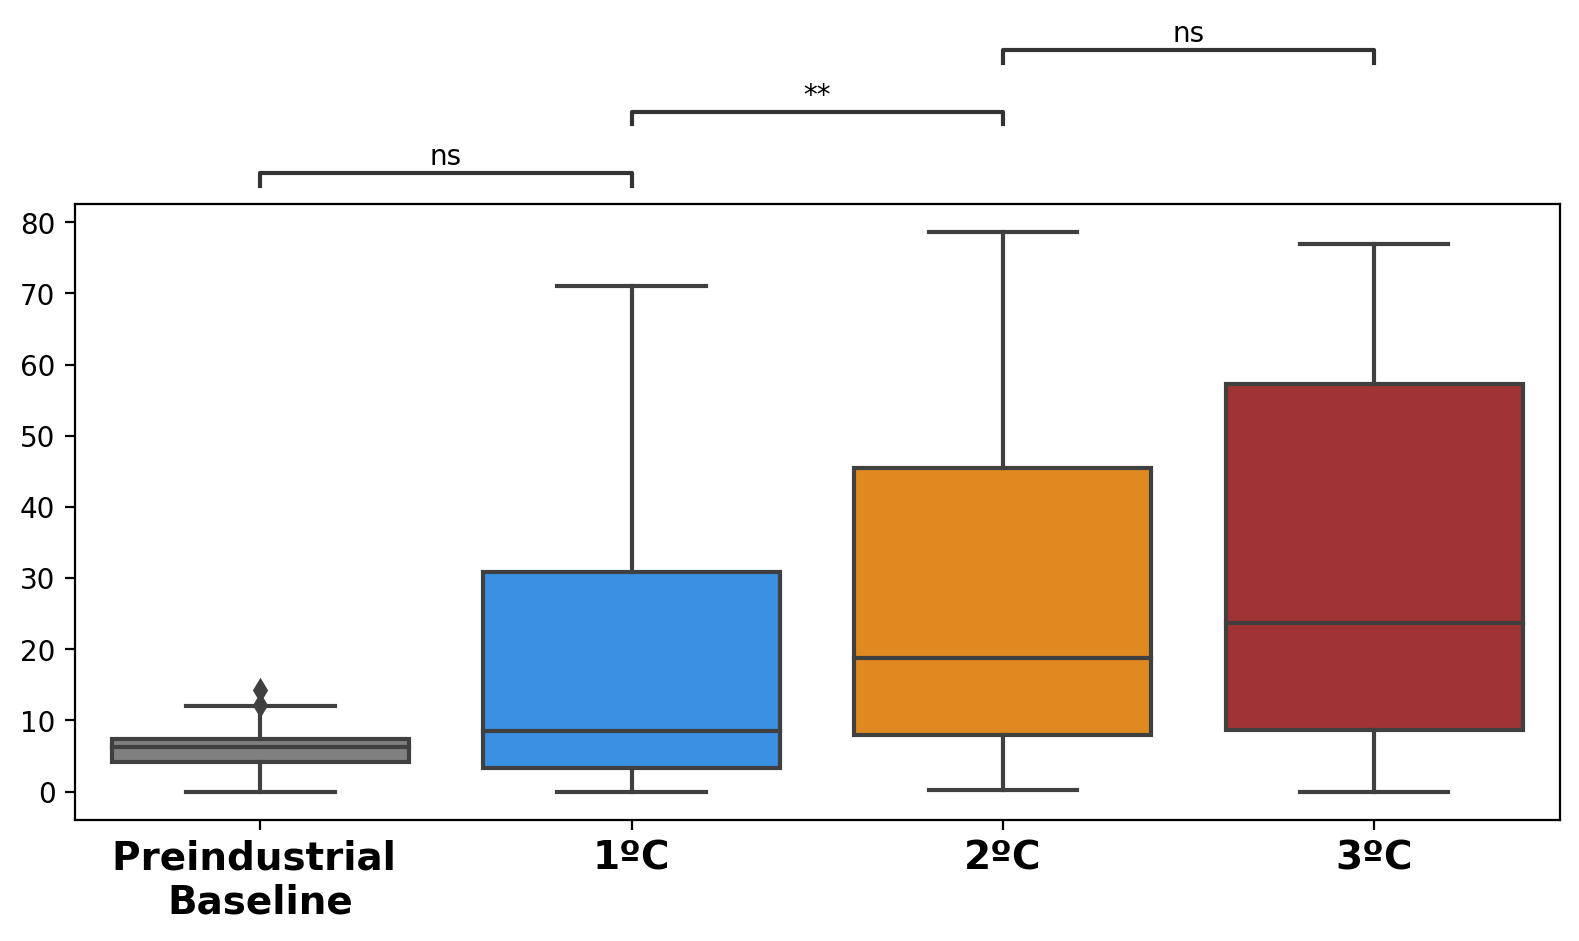

In [71]:
region = 'WNA'
event = 'sm_200_high_spi_6_events'

boxplot_relative_event_likelihood(relative_events_likelihood, region, event, percentile = 'low_percentile')

### SPI 1 Month for surface and 3 months for root zone

In [72]:
spi_1_3 = ['sm_surface_low_pr_events', 'sm_surface_high_pr_events',  'sm_200_low_spi_3_events',  'sm_200_high_spi_3_events']

spi_3_MED_events = {k: relative_events_likelihood['MED'][k] for k in relative_events_likelihood['MED'].keys() & spi_1_3}

spi_3_WNA_events = {k: relative_events_likelihood['WNA'][k] for k in relative_events_likelihood['WNA'].keys() & spi_1_3}

boxplot_relative_event_likelihood(spi_3_MED_events, 'MED', order = spi_1_3)
boxplot_relative_event_likelihood(spi_3_WNA_events, 'WNA', order = spi_1_3)


TypeError: boxplot_relative_event_likelihood() got an unexpected keyword argument 'order'

### SPI 1 Month for surface and root zone

In [ ]:
spi_1_1 = ['sm_surface_low_pr_events', 'sm_surface_high_pr_events', 'sm_200_low_spi_1_events', 'sm_200_high_spi_1_events']

spi_1_MED_events = {k: relative_events_likelihood['MED'][k] for k in relative_events_likelihood['MED'].keys() & spi_1_1}

spi_1_WNA_events = {k: relative_events_likelihood['WNA'][k] for k in relative_events_likelihood['WNA'].keys() & spi_1_1}

boxplot_relative_event_likelihood(spi_1_MED_events, 'MED', order = spi_1_1)
boxplot_relative_event_likelihood(spi_1_WNA_events, 'WNA', order = spi_1_1)

In [81]:
## TO DO
# add rounding
# add longname to conditional event titles

In [82]:
def conditional_changes_calculation(region, event, percentile, percentile_number, mean_or_median):
    region_longname = reg_longname(region)

    if mean_or_median == 'MEDIAN':
        print('MEDIAN CHANGE')
        
    print(region_longname + ' changes in a ' + str(percentile_number) + 'th percentile ' + event + ': ')
    
    median_change = relative_events_likelihood[region][event].groupby('warming_level').median()


    print(str(np.round(multiple_more_likely(median_change[percentile][-1], median_change[percentile][1]), 2)) + ' times more likely at 2ºC')
    print(str(np.round(percent_increase(median_change[percentile][-1], median_change[percentile][1]), 2)) + ' percent increase at 2ºC')

    print(str(np.round(multiple_more_likely(median_change[percentile][-1], median_change[percentile][2]), 2)) + ' times more likely at 3ºC')
    print(str(np.round(percent_increase(median_change[percentile][-1], median_change[percentile][2]), 2)) + ' percent increase at 3ºC')

    if mean_or_median == 'MEDIAN':
        print(relative_events_likelihood[region][event].groupby('warming_level').median())


In [83]:
def print_statement_conditional(median_change):
    
    print(str(multiple_more_likely(median_change[percentile][-1], median_change[percentile][1])) + ' times more likely at 2ºC')
    print(str(percent_increase(median_change[percentile][-1], median_change[percentile][1])) + ' percent increase at 2ºC')

    print(str(multiple_more_likely(median_change[percentile][-1], median_change[percentile][2])) + ' times more likely at 3ºC')
    print(str(percent_increase(median_change[percentile][-1], median_change[percentile][2])) + ' percent increase at 3ºC')

### Getting values

In [84]:
relative_events_likelihood['MED'].keys()

dict_keys(['sm_surface_low_pr_events', 'sm_surface_high_pr_events', 'sm_200_low_spi_1_events', 'sm_200_high_spi_1_events', 'sm_200_low_spi_3_events', 'sm_200_high_spi_3_events', 'sm_200_low_spi_6_events', 'sm_200_high_spi_6_events'])

In [87]:
region = 'WNA'
#event_key = 'sm_surface_low_pr_events'
#event_key = 'sm_surface_high_pr_events'
#event_key = 'sm_200_low_spi_6_events'
event_key = 'sm_200_high_spi_6_events'

In [88]:
relative_events_likelihood[region][event_key].groupby(['warming_level', 'variable']).mean()[['high_percentile']]

,,high_percentile
warming_level,variable,
1,mrsol_anom,59.354672
2,mrsol_anom,52.728416
3,mrsol_anom,53.185565
baseline,mrsol_anom,70.822568


#### Dry surface soils during low and high precipitation events:

In [49]:
conditional_changes_calculation('MED', 'sm_surface_low_pr_events', 'low_percentile', 25, 'MEDIAN')

MEDIAN CHANGE
Mediterranean changes in a 25th percentile sm_surface_low_pr_events: 
1.37 times more likely at 2ºC
36.75 percent increase at 2ºC
1.39 times more likely at 3ºC
39.05 percent increase at 3ºC
               low_percentile  high_percentile
warming_level                                 
1                   86.250000         2.966102
2                   95.873016         0.634921
3                   97.491039         0.253807
baseline            70.110701         4.477612


In [50]:
conditional_changes_calculation('WNA', 'sm_surface_low_pr_events', 'low_percentile', 25, 'MEDIAN')

MEDIAN CHANGE
Western North America changes in a 25th percentile sm_surface_low_pr_events: 
1.27 times more likely at 2ºC
27.39 percent increase at 2ºC
1.36 times more likely at 3ºC
35.94 percent increase at 3ºC
               low_percentile  high_percentile
warming_level                                 
1                   73.584906         5.701754
2                   85.693431         1.895735
3                   91.440217         1.129283
baseline            67.267267         8.208955


In [51]:
conditional_changes_calculation('WNA', 'sm_surface_low_pr_events', 'high_percentile', 75, 'MEDIAN')

MEDIAN CHANGE
Western North America changes in a 75th percentile sm_surface_low_pr_events: 
4.33 times more likely at 2ºC
-76.91 percent increase at 2ºC
7.27 times more likely at 3ºC
-86.24 percent increase at 3ºC
               low_percentile  high_percentile
warming_level                                 
1                   73.584906         5.701754
2                   85.693431         1.895735
3                   91.440217         1.129283
baseline            67.267267         8.208955


#### Wet surface soils during low and high precipitation events:

In [52]:
conditional_changes_calculation('WNA', 'sm_surface_high_pr_events', 'low_percentile', 25, 'MEDIAN')

MEDIAN CHANGE
Western North America changes in a 25th percentile sm_surface_high_pr_events: 
3.24 times more likely at 2ºC
223.93 percent increase at 2ºC
4.06 times more likely at 3ºC
305.95 percent increase at 3ºC
               low_percentile  high_percentile
warming_level                                 
1                   14.583333        60.256410
2                   29.447853        51.162791
3                   36.904762        41.511628
baseline             9.090909        68.750000


In [53]:
conditional_changes_calculation('WNA', 'sm_surface_high_pr_events', 'high_percentile', 75, 'MEDIAN')

MEDIAN CHANGE
Western North America changes in a 75th percentile sm_surface_high_pr_events: 
1.34 times more likely at 2ºC
-25.58 percent increase at 2ºC
1.66 times more likely at 3ºC
-39.62 percent increase at 3ºC
               low_percentile  high_percentile
warming_level                                 
1                   14.583333        60.256410
2                   29.447853        51.162791
3                   36.904762        41.511628
baseline             9.090909        68.750000


In [54]:
region = 'WNA'
event = 'sm_200_low_spi_6_events'
percentile = 'low_percentile'

tmp_array = relative_events_likelihood[region][event].groupby('warming_level').mean()[percentile]
multiple_more_likely(tmp_array[-1], tmp_array[1])

1.0560836218032719

In [55]:
region = 'WNA'
event = 'sm_surface_low_pr_events'
percentile = 'low_percentile'

tmp_array = relative_events_likelihood[region][event].groupby('warming_level').mean()[percentile]

percent_increase(tmp_array[-1], tmp_array[1])


32.17186488349778

In [56]:
region = 'WNA'
event = 'sm_200_low_spi_6_events'
percentile = 'low_percentile'

tmp_array = relative_events_likelihood[region][event].groupby('warming_level').mean()[percentile]

percent_increase(tmp_array[-1], tmp_array[1])


5.608362180327191

In [57]:
region = 'WNA'
event = 'sm_surface_high_pr_events'
percentile = 'low_percentile'

tmp_array = relative_events_likelihood[region][event].groupby('warming_level').mean()[percentile]
multiple_more_likely(tmp_array[-1], tmp_array[1])

3.3244407042650788

In [58]:
region = 'MED'
event = 'sm_surface_high_pr_events'
percentile = 'high_percentile'

tmp_array = relative_events_likelihood[region][event].groupby('warming_level').mean()[percentile]
percent_increase(tmp_array[-1], tmp_array[1])


-42.029766548343865